In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.metrics import r2_score

# Data Construction

There was no dataset available so I had to create my own. I chose to start with an array that I manually update instead of a google spreadsheet/CSV that I'd manually update & import so that I could use arrays (note how I track sources). 

I did publish my dataset at [bit.ly/lacovid19](http://bit.ly/lacovid19)

In [637]:
# cases = total LA County reported case counts
# deaths = total LA County reported deaths
# ladph_new = LA County Department of Health announced new cases that day, usually excludes Long Beach & Pasadena. 
#             Should equal difference between today & yesterday's cases
# source = URL references for the numbers
# community_transmitted = LA County reported community transmissions (included in "cases")
# long_beach = Long Beach total reported cases (included in "cases")
# pasadena = Pasadena total reported cases (included in "cases")
# note = any relevant notes for that day.


data = {"2020-03-04" : {"cases" : 7, "deaths" : 0, "ladph_new" : 6, "total_tests": None, "source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2249" },
        "2020-03-05" : {"cases" : 11, "deaths" : 0, "ladph_new" : 4, "hospitalized" : 2,  "source" : ["http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2250","https://www.facebook.com/drsamfink/posts/10213560620330340"],
                       "note" : "2 hospitalizations inferred from Dr. in Tarzana talking about 2 patients from Italy trip."},
        "2020-03-06" : {"cases" : 13, "deaths" : 0, "ladph_new" : 2, "note" : "First day commercial labs became available.","source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2253" },
        "2020-03-07" : {"cases" : 14, "deaths" : 0, "ladph_new" : 1,  "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2256" },
        "2020-03-08" : {"cases" : 14, "deaths" : 0, "ladph_new" : 0, "source" : "https://lacounty.maps.arcgis.com/apps/opsdashboard/index.html#/3db641e60de9451fa70e69dd5dadbce4"},
        "2020-03-09" : {"cases" : 16, "deaths" : 0, "ladph_new" : 2,  "community_transmitted" : 1, "ladph_tests" : 60,
                        "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2258"},
        "2020-03-10" : {"cases" : 20, "deaths" : 0, "ladph_new" : 1, "long_beach" : 3, "community_transmitted" : 1, "source" : ["http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2260",
                                                                                               "https://www.dailynews.com/2020/03/10/confirmed-la-county-coronavirus-cases-now-total-20/"]}, # 
        "2020-03-11" : {"cases" : 27, "deaths" : 1, "ladph_new" : 6, "long_beach" : 4, "pasadena" : 0, "ladph_tests" : 72, "community_transmitted" : 2, "new_hospitalizations" : 1,
                        "note" : "2 new commercial labs coming online. LA Public Health dept can do 30 tests/day, need more machines. Have materials to run '100s and 100s of tests.' 1000 beds are available for a surge across the hospital system. Dr. Ferrera does not believe testing everyone would be useful.",
                        "source" : ["http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2261",
                                                                                                "https://www.dailynews.com/2020/03/11/4th-person-tests-positive-for-coronavirus-in-long-beach/",
                                                                                               "https://www.dailybreeze.com/2020/03/11/la-county-reports-first-death-related-to-coronavirus-6-new-cases/"
                                                                                              ]},
        "2020-03-12" : {"cases" : 32, "deaths" : 1, "ladph_new" : 3, "long_beach" : 4, "pasadena" : 1, "total_tests" : 247, "cdc_tests" : 27, "commercial_tests" : 120,"ladph_tests" : 100, "community_transmitted" : 4, "new_hospitalizations" : 1, 
                        "note" : "LA Public Health Dept. got 700-800 new tests on March 10.",
                        "source" : ["http://ph.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2264",
                                                                                                                             "https://www.dailynews.com/2020/03/12/la-county-health-officials-announce-3-new-coronavirus-cases-including-more-community-spread/",
                                                                                                                                            "https://www.pasadenastarnews.com/2020/03/11/pasadena-reports-its-first-confirmed-case-of-coronavirus/"]}, 
        "2020-03-13" : {"cases" : 40, "deaths" : 1, "ladph_new" : 8, "long_beach" : 4, "pasadena" : 1,"community_transmitted" : 6,"new_hospitalizations" : 2, "source" : ["http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2262",
                                                                                                                            "https://www.dailynews.com/2020/03/13/total-coronavirus-cases-in-la-county-rise-to-40-after-health-officials-announce-8-new-ones/",
                                                                                                                            "https://www.facebook.com/lapublichealth/videos/2601987390036773"],
                       "note" : "25% of public health tests are positive. Commercial labs are seeing 4% positive. CDC/Atlanta at 11% positive."}, # 41 if including extra
        "2020-03-14" : {"cases" : 53, "deaths" : 1, "ladph_new" : 11,"long_beach" : 5, "pasadena" : 1,"community_transmitted" : 8, "source" : ["http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2265",
                                                                                                                            "https://www.dailynews.com/2020/03/14/11-new-la-county-coronavirus-cases-officials-say-total-now-53/",
                                                                                                                            "https://www.latimes.com/california/story/2020-03-14/supermakets-mobbed-street-clear-as-coronavirus-spreads-across-california",
                                                                                                                             "https://www.foxla.com/news/5th-case-of-covid-19-confirmed-in-long-beach-first-known-case-of-community-transmission"]
                                                                                                                            }, # 54 if including the extra
        "2020-03-15" : {"cases" : 69, "deaths" : 1, "ladph_new" : 16, "long_beach" : 6, "pasadena" : 1, "community_transmitted" : 10, "source" : ["https://twitter.com/lapublichealth/status/1239273555340046336"]},
        "2020-03-16" : {"cases" : 94, "deaths" : 1, "ladph_new" : 25, "note": "LB discrepancy, reported total of 5 today.", "long_beach" : 5, "pasadena" : 2, "community_transmitted" : 15, "new_hospitalizations" : 2, "source" : ["http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2268", "https://www.facebook.com/lapublichealth/videos/205067544141294"]},
        "2020-03-17" : {"cases" : 144, "deaths" : 1, "ladph_new" : 50, "long_beach" : 8, "total_tests" : "1144", "cdc_tests" : 38, "commercial_tests" : 900,"ladph_tests" : 206,  "community_transmitted": None, 
                                        "note" : "More testing came online. Commercial labs 7% positive, CDC & Public Health labs are 24%.", "pasadena" : 2, "source" : ["http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2271","https://www.facebook.com/lapublichealth/videos/137870180981495/","https://www.cityofpasadena.net/public-health/news-announcements/information-on-covid-19/","https://laist.com/latest/post/20200317/long-beach-coronavirus-cases","https://www.dailynews.com/2020/03/17/50-new-coronavirus-cases-reported-in-los-angeles-county-as-leaders-announce-financial-relief-steps/?utm_source=twitter.com&utm_medium=social&utm_campaign=socialflow&utm_content=tw-ladailynews"], },
        "2020-03-18" : {"cases" : 190, "deaths": 1, "ladph_new" : 46, "long_beach" : 8, "pasadena" : 2,  "source" : ["https://www.facebook.com/countyofla/posts/3250707084962573"]},
        "2020-03-19" : {"cases" : 231, "deaths": 2, "ladph_new" : 40, "long_beach" : 10, "pasadena" : 2, "total_tests" : 1700, "source" : ["https://twitter.com/lapublichealth/status/1240770368547127296/photo/1","https://www.facebook.com/countyofla/videos/203740024217190/"], 
                                        "note" : "LADPH says test capacity is increasing but limited. Public health lab (7 labs) has 21% positive rate, commercial labs have 10% positive. Must have symptoms of respiratory illness. Even close contact w/o symptoms, no test, but mandatory quarantine."},
        "2020-03-20" : {"cases" : 292, "deaths": 2, "ladph_new" : 61, "long_beach" : 12, "pasadena" : 2, "hospitalized": 48, "total_tests" : 2400, "source" : ["https://www.facebook.com/countyofla/videos/248599956304949","https://twitter.com/lapublichealth/status/1241097919941369856"],
                       "note": "Median age: 47. 138 cases between ages of 18-65."},
        "2020-03-21" : {"cases" : 351, "deaths" : 4, "ladph_new": 59, "long_beach" : 13, "pasadena" : 3, "hospitalized": 69, "source" : "https://twitter.com/lapublichealth/status/1241548664960471040"},
        "2020-03-22" : {"cases" : 409, "deaths" : 5, "ladph_new": 71, "long_beach" : 15, "pasadena" : 3, "hospitalized": 84, 
                        "age_0_17" : 5, "age_18_40" : 160, "age_41_65" : 159, "age_65_plus" : 67,
                        "source" : "https://twitter.com/lapublichealth/status/1241836672465002496/photo/2"},
        "2020-03-23" : {"cases": 536, "deaths" : 7, "ladph_new" : 128, "hospitalized" : 90, "long_beach": 17,"pasadena":3, "total_tests" : 4700, 
                        "age_0_17" : 9, "age_18_40" : 217, "age_41_65" : 198, "age_65_plus" : 92,
                        "note" : "80% of cases are 18-65, 42% of cases are 18-40. About 10% of tests are positive.",
                        "source" : ["https://www.facebook.com/countyofla/videos/529718971063589/","https://twitter.com/CBSLA/status/1242181473240666112","http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2279"]
                       },
        
        "2020-03-24" :{"cases": 662, "deaths" : 10, "ladph_new" : 128,"hospitalized" : 119, "long_beach" : 22, "pasadena" : 6, "total_tests" : 5700,
                        "age_0_17" : 10, "age_18_40" : 268, "age_41_65" : 250, "age_65_plus" : 107,
                       "note" : "Death of 1 <18 year old removed due to under investigation by CDC.",
                       "source" : ["https://www.facebook.com/countyofla/videos/2810640562389105/","http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2280"]
                      },
        "2020-03-25" : {"cases": 799, "deaths" : 13, "ladph_new" : 138,  "long_beach" : 28, "hospitalized" : 160, "pasadena" : 7, "total_tests" : 6300,
                         "age_0_17" : 10, "age_18_40" : 310, "age_41_65" : 303, "age_65_plus" : 141,
                        "note" : "LA County has 1500 open beds, 220 are ICU hospital beds with 100% of hospitals reporting. There are 820 available ventilators.",
                       "source" : ["https://www.facebook.com/countyofla/videos/1154200105043887","https://twitter.com/CountyofLA/status/1242909668235563008/photo/1"]},
        "2020-03-26" : {"cases" : 1216, "deaths" : 21, "ladph_new" : 421, "long_beach" : 41, "pasadena" : 9, "hospitalized" : 253, "total_tests" : 9400,
                         "age_0_17" : 19, "age_18_40" : 462, "age_41_65" : 462, "age_65_plus" : 223,
                        "note" : "Testing capacity is increasing but still limited. Only symptomatic should be tested.",
                       "source" : ["https://www.facebook.com/countyofla/videos/819857095172036/","http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&prog=media&prid=2284"]},
        "2020-03-27" : {"cases" : 1465, "deaths" : 26, "ladph_new" : 257, "hospitalized" : 317, "total_tests" : 11000,
                       "long_beach": 54, "pasadena" : 9, "long_beach_deaths" : 1, "pasadena_deaths" : 0,
                         "age_0_17" : 22, "age_18_40" : 547, "age_41_65" : 565, "age_65_plus" : 268,
                        "note" : "Confirmed data fluctuations are due in part to inconsistencies in volume returned from commercial labs like Quest Labs.",
                       "source" : ["https://www.facebook.com/countyofla/videos/254402685591090"]},
        "2020-03-28" : {"cases" : 1804, "deaths" : 32, "ladph_new" : 344, "hospitalized" : 398,
                        "age_0_17" : 27, "age_18_40" : 674, "age_41_65" : 676, "age_65_plus" : 343,
                        "note" : "3 cases removed for not being LAC.",
                        "source" : "https://twitter.com/lapublichealth/status/1244018062497427456/photo/1"
                       },
        "2020-03-29" : {"cases" : 2136, "deaths" : 37, "ladph_new" : 332, "hospitalized" : 453,
                        "long_beach": 88, "pasadena" : 10, "long_beach_deaths" : 1, "pasadena_deaths" : 0,
                        "age_0_17" : 34, "age_18_40" : 812, "age_41_65" : 797, "age_65_plus" : 395,
                       "source" : "https://twitter.com/lapublichealth/status/1244384849894367232"},
        "2020-03-30" : {"cases" : 2474, "deaths" : 44, "ladph_new" : 342, "hospitalized" : 492,"total_tests" : 15500, "la_city_tests" : 6741,
                        "long_beach": 99, "pasadena" : 10, "long_beach_deaths" : 1, "pasadena_deaths" : 0,
                       "age_0_17" : 37, "age_18_40" : 918, "age_41_65" : 943, "age_65_plus" : 467,                        
                       "source" : ["https://www.facebook.com/countyofla/videos/1051248235260976/","https://mailchi.mp/lamayor.org/covid-19-testing-and-more-updates"]},
        "2020-03-31" : {"cases" : 3011, "deaths" : 54, "ladph_new" : 548, "hospitalized" : 594, "total_tests" : 19300,
                        "long_beach" : 115, "pasadena" : 25,"long_beach_deaths" : 1, "pasadena_deaths" : 0,
                         "age_0_17" : 27, "age_18_40" : 1101, "age_41_65" : 1172, "age_65_plus" : 553, "age_unknown" : 18,                        
                       "note" : "87% of deaths had underlying conditions. New testing capacity announced. Long waits still exist for test results.",#" 267 current hospitalized, 173 are 55 years of age or older. 25% in ICU.",
                       "source" : ["https://www.pscp.tv/w/1zqJVlbqygaKB"]},
        "2020-04-01" : {"cases" : 3518, "deaths" : 65 , "ladph_new" : 513, "hospitalized" : 733, "total_tests" : 21000,
                         "age_0_17" : 32, "age_18_40" : 1228, "age_41_65" : 1399, "age_65_plus" : 669, "age_unknown" : 24,                        
                         "long_beach" : 133, "pasadena" : 33, "long_beach_deaths" : 1, "pasadena_deaths" : 0,
                        "note" : "5 positives are homeless. 341 current hospitalized. 20% in ICU. 76% of those hospitalized have no underlying conditions. ",
                        "source" : ["https://www.facebook.com/countyofla/videos/505981283414084"]
                       }

}

In [638]:
# convert to pandas dataframe
df = pd.DataFrame(data).T

# recognize index as dates
df.index = pd.to_datetime(df.index)

# use day count, for math functions
df["days"] = df.index - df.index[0]
df["days"] = (df.days / 86400000000000).astype(int)

# fill in the blanks with 0s for numerical columns. 
#df[df.columns[~df.columns.isin(["source","note"])]] = df[df.columns[~df.columns.isin(["source","note"])]].fillna(0)

# move days column to the front. don't risk dropping columns
df = df[list(df.columns[-1:]) + list(df.columns[:-1])]

colorder = ["days","cases","community_transmitted","deaths","hospitalized","ladph_new","long_beach","pasadena", "age_0_17", "age_18_40" , "age_41_65" , "age_65_plus","age_unknown", "total_tests","cdc_tests","ladph_tests","commercial_tests","la_city_tests","note","source"]
print "Column discrepancy", len(colorder) - len(df.columns)
df = df[colorder]
df

Column discrepancy -3


,days,cases,community_transmitted,deaths,hospitalized,ladph_new,long_beach,pasadena,age_0_17,age_18_40,age_41_65,age_65_plus,age_unknown,total_tests,cdc_tests,ladph_tests,commercial_tests,la_city_tests,note,source
2020-03-04,0,7,NaN,0,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,http://www.publichealth.lacounty.gov/phcommon/...
2020-03-05,1,11,NaN,0,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 hospitalizations inferred from Dr. in Tarzan...,[http://publichealth.lacounty.gov/phcommon/pub...
2020-03-06,2,13,NaN,0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,First day commercial labs became available.,http://www.publichealth.lacounty.gov/phcommon/...
2020-03-07,3,14,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://publichealth.lacounty.gov/phcommon/publ...
2020-03-08,4,14,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://lacounty.maps.arcgis.com/apps/opsdashb...
2020-03-09,5,16,1,0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,http://publichealth.lacounty.gov/phcommon/publ...
2020-03-10,6,20,1,0,NaN,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[http://publichealth.lacounty.gov/phcommon/pub...
2020-03-11,7,27,2,1,NaN,6,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,NaN,NaN,2 new commercial labs coming online. LA Public...,[http://publichealth.lacounty.gov/phcommon/pub...
2020-03-12,8,32,4,1,NaN,3,4,1,NaN,NaN,NaN,NaN,NaN,247,27,100,120,NaN,LA Public Health Dept. got 700-800 new tests o...,[http://ph.lacounty.gov/phcommon/public/media/...
2020-03-13,9,40,6,1,NaN,8,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25% of public health tests are positive. Comme...,[http://publichealth.lacounty.gov/phcommon/pub...


# Analysis

So technically with an exponential fit, you'd use a linear regression to estimate the coefficients. However, with an accelerating growth rate in LA, it wasn't performing very well at estimating the most recent data points, which were probably the most reliable.

So I also included a straight curve fit, which will bias towards more recent data points (as the error for getting those wrong is heavier). Does more poorly on earlier data points, but also is more consistent with national averages at time of writing (about ~33% daily growth)

R^2 0.9949133300609063
LinregressResult(slope=0.2320601226189573, intercept=1.8329947756069354, rvalue=0.9968567860358681, pvalue=2.8362349284680276e-31, stderr=0.0035493293269759614) 1.2611955529285943


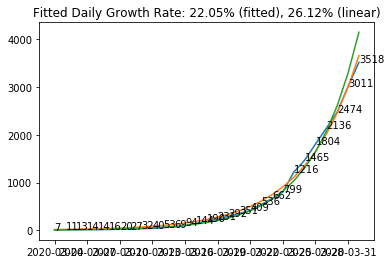

In [639]:
# plot cases
plt.plot(df.index, df.cases)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  df.days,  df.cases,  p0=(7, np.log(1.33)))

# plot fit #1
plt.plot(df.index, cf[0][0] * np.exp(cf[0][1]*df.days))

# store it for exporting. if the variable is number of days, then e^b is our daily multiplier. 
# subtract 1 to get growth rate, multiply by 100 for a formatted %. 
df["cases_pred_{}pct_curvefit".format(int((np.exp(cf[0][1]) - 1)*100))] = cf[0][0] * np.exp(cf[0][1]*df.days)

# calculate R^2 for the curve fit
print "R^2", r2_score(df.cases, cf[0][0] * np.exp(cf[0][1]*df.days))

# fit #2: linear regression. take the ln() of case count. 
# For exponential growth, we have cases = (day 1 cases) * (daily growth rate)^(days)
# It becomes linear with ln(cases) = ln(day 1 cases) + (days) * ln(daily growth rate)
# This linear in (days), with slope = ln(daily growth rate) and intercept = ln(day 1 cases)
lr = linregress(df.days, y=df.cases.map(np.log))

# print results + growth rate
print lr, np.exp(lr.slope)

# plot fit #2
plt.plot(df.index, np.exp(lr.intercept) * np.exp(lr.slope*df.days))

# store it for exporting. 
# if slope = ln(daily growth rate) , then daily growth rate = e^slope. Subtract 1. 
df["cases_pred_{}pct_linreg".format(int((np.exp(lr.slope)-1)*100))] =  np.exp(lr.intercept) * np.exp(lr.slope*df.days)

# Show both growth rates in the title. 
plt.title("Fitted Daily Growth Rate: {:0.2f}% (fitted), {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100,(np.exp(lr.slope)-1)*100))
for i,r in df.iterrows():
    plt.text(i, r.cases+2, int(r.cases))
    


R^2 0.97977262010346
LinregressResult(slope=0.23152094636672005, intercept=0.2501830587120022, rvalue=0.9904996774048834, pvalue=7.883936916006267e-11, stderr=0.009691474112661077) 1.2605157295258145


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Text(0.5,1,'Hospitalized Growth Rate: 21.71% (fitted), 26.05% (linear)')

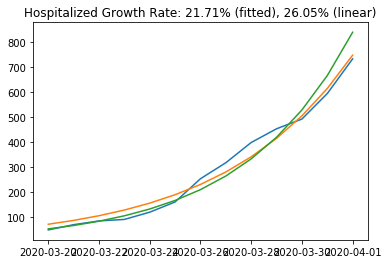

In [640]:
### GROWTH IN HOSPITALIZED

x = df.index[16:]
x0 = df.days[16:]
y = df.hospitalized[16:].fillna(method='ffill').astype(int)

# plot cases
plt.plot(x, y)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))

# plot fit #1
plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))

# store it for exporting. if the variable is number of days, then e^b is our daily multiplier. 
# subtract 1 to get growth rate, multiply by 100 for a formatted %. 
#df["cases_pred_{}pct_curvefit".format(int((np.exp(cf[0][1]) - 1)*100))] = cf[0][0] * np.exp(cf[0][1]*x0)

# calculate R^2 for the curve fit
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))

# fit #2: linear regression. take the ln() of case count. 
# For exponential growth, we have cases = (day 1 cases) * (daily growth rate)^(days)
# It becomes linear with ln(cases) = ln(day 1 cases) + (days) * ln(daily growth rate)
# This linear in (days), with slope = ln(daily growth rate) and intercept = ln(day 1 cases)
lr = linregress(x0, y=y.map(np.log))

# print results + growth rate
print lr, np.exp(lr.slope)

# plot fit #2
plt.plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))

# store it for exporting. 
# if slope = ln(daily growth rate) , then daily growth rate = e^slope. Subtract 1. 
df.ix[16:,"hospitalized_pred_{}pct_linreg".format(int((np.exp(lr.slope)-1)*100))] =  np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
plt.title("Hospitalized Growth Rate: {:0.2f}% (fitted), {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100,(np.exp(lr.slope)-1)*100))
#for i,r in df.iterrows():
#    plt.text(i, r.cases+2, int(r.cases))
    


R^2 0.9864516668642528
LinregressResult(slope=0.16640180148771402, intercept=1.9224034101091325, rvalue=0.9922056899346519, pvalue=1.0258461045493562e-05, stderr=0.009346031396257183) 1.1810475530631475
R^2 0.998444930636924
LinregressResult(slope=0.17655862338232758, intercept=3.2355560570720403, rvalue=0.9990715307873292, pvalue=5.042623679480995e-08, stderr=0.0034049071158523004) 1.193104368523019


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Text(0.5,1,'Cases Growth Rate: 18.96% (fitted), 19.31% (linear)')

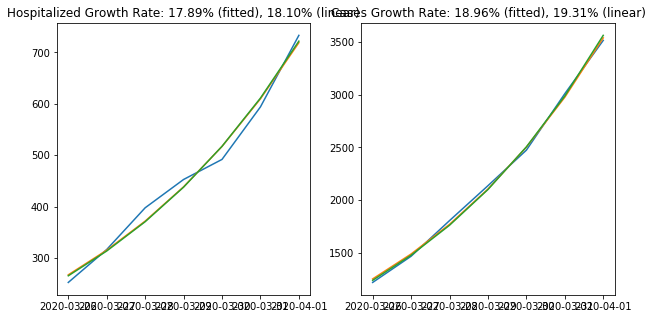

In [641]:
### LAST 7 DAYS

fig, ax = plt.subplots(1,2, figsize=(10,5))

x = df.index[-7:]
x0 = df.days[-7:]
y = df.hospitalized[-7:].fillna(method='ffill').astype(int)

# plot cases
ax[0].plot(x, y)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))

# plot fit #1
ax[0].plot(x, cf[0][0] * np.exp(cf[0][1]*x0))

# store it for exporting. if the variable is number of days, then e^b is our daily multiplier. 
# subtract 1 to get growth rate, multiply by 100 for a formatted %. 
#df["cases_pred_{}pct_curvefit".format(int((np.exp(cf[0][1]) - 1)*100))] = cf[0][0] * np.exp(cf[0][1]*x0)

# calculate R^2 for the curve fit
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))

# fit #2: linear regression. take the ln() of case count. 
# For exponential growth, we have cases = (day 1 cases) * (daily growth rate)^(days)
# It becomes linear with ln(cases) = ln(day 1 cases) + (days) * ln(daily growth rate)
# This linear in (days), with slope = ln(daily growth rate) and intercept = ln(day 1 cases)
lr = linregress(x0, y=y.map(np.log))

# print results + growth rate
print lr, np.exp(lr.slope)

# plot fit #2
ax[0].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))

# store it for exporting. 
# if slope = ln(daily growth rate) , then daily growth rate = e^slope. Subtract 1. 
df.ix[16:,"hospitalized_pred_last7"] =  np.exp(lr.intercept) * np.exp(lr.slope*df.days[16:])

# Show both growth rates in the title. 
ax[0].set_title("Hospitalized Growth Rate: {:0.2f}% (fitted), {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100,(np.exp(lr.slope)-1)*100))
#for i,r in df.iterrows():
#    plt.text(i, r.cases+2, int(r.cases))




### CASES

x = df.index[-7:]
x0 = df.days[-7:]
y = df.cases[-7:]

# plot cases
ax[1].plot(x, y)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))

# plot fit #1
ax[1].plot(x, cf[0][0] * np.exp(cf[0][1]*x0))

# store it for exporting. if the variable is number of days, then e^b is our daily multiplier. 
# subtract 1 to get growth rate, multiply by 100 for a formatted %. 
#df["cases_pred_{}pct_curvefit".format(int((np.exp(cf[0][1]) - 1)*100))] = cf[0][0] * np.exp(cf[0][1]*x0)

# calculate R^2 for the curve fit
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))

# fit #2: linear regression. take the ln() of case count. 
# For exponential growth, we have cases = (day 1 cases) * (daily growth rate)^(days)
# It becomes linear with ln(cases) = ln(day 1 cases) + (days) * ln(daily growth rate)
# This linear in (days), with slope = ln(daily growth rate) and intercept = ln(day 1 cases)
lr = linregress(x0, y=y.map(np.log))

# print results + growth rate
print lr, np.exp(lr.slope)

# plot fit #2
ax[1].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))

# store it for exporting. 
# if slope = ln(daily growth rate) , then daily growth rate = e^slope. Subtract 1. 
df["cases_pred_last7"] =  np.exp(lr.intercept) * np.exp(lr.slope*df.days)

# Show both growth rates in the title. 
ax[1].set_title("Cases Growth Rate: {:0.2f}% (fitted), {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100,(np.exp(lr.slope)-1)*100))
#for i,r in df.iterrows():
#    plt.text(i, r.cases+2, int(r.cases))

    


In [642]:
df.to_csv("lacv.csv")

R^2 0.9850217362445794
LinregressResult(slope=0.22432397037079188, intercept=4.042908864734245, rvalue=0.990134358830358, pvalue=5.430406413536946e-09, stderr=0.010581912194197848) 1.2514763950317103


Text(1.58509e+18,0,'Twitter: @liora_')

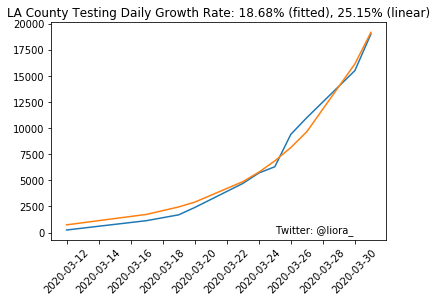

In [490]:
### GROWTH IN TESTS

x = df[df.total_tests.notnull()].index#[8:-2]
x0 = df[df.total_tests.notnull()].days#[8:-2]
y = df[df.total_tests.notnull()].total_tests.astype(int)#[8:-2].fillna(method='ffill').astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))

# plot fit #1
plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))

# calculate R^2 for the curve fit
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))

lr = linregress(x0, y=y.map(np.log))

# print results + growth rate
print lr, np.exp(lr.slope)

# plot fit #2
#plt.plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))

# Show both growth rates in the title. 
plt.title("LA County Testing Daily Growth Rate: {:0.2f}% (fitted), {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100,(np.exp(lr.slope)-1)*100))
#for i,r in df.iterrows():
#    plt.text(i, r.cases+2, int(r.cases))
plt.xticks(rotation=45)
    
plt.text(x.values[-5], 0, "Twitter: @liora_")

In [152]:
df

,days,cases,community_transmitted,deaths,hospitalized,ladph_new,long_beach,pasadena,age_0_17,age_18_40,...,total_tests,cdc_tests,ladph_tests,commercial_tests,note,source,cases_pred_25pct_curvefit,cases_pred_26pct_linreg,cases_pred_28pct_curvefit,hospitalized_pred_29pct_linreg
2020-03-04,0,7,NaN,0,NaN,6,NaN,NaN,NaN,NaN,...,None,NaN,NaN,NaN,NaN,http://www.publichealth.lacounty.gov/phcommon/...,7.062053,6.085038,NaN,NaN
2020-03-05,1,11,NaN,0,2,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2 hospitalizations inferred from Dr. in Tarzan...,[http://publichealth.lacounty.gov/phcommon/pub...,8.887222,7.698376,NaN,NaN
2020-03-06,2,13,NaN,0,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,First day commercial labs became available.,http://www.publichealth.lacounty.gov/phcommon/...,11.184101,9.739461,NaN,NaN
2020-03-07,3,14,NaN,0,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,http://publichealth.lacounty.gov/phcommon/publ...,14.074603,12.321703,NaN,NaN
2020-03-08,4,14,NaN,0,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,https://lacounty.maps.arcgis.com/apps/opsdashb...,17.712147,15.588580,NaN,NaN
2020-03-09,5,16,1,0,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,60,NaN,NaN,http://publichealth.lacounty.gov/phcommon/publ...,22.289806,19.721610,NaN,NaN
2020-03-10,6,20,1,0,NaN,1,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[http://publichealth.lacounty.gov/phcommon/pub...,28.050548,24.950439,NaN,NaN
2020-03-11,7,27,2,1,NaN,6,4,0,NaN,NaN,...,NaN,NaN,72,NaN,2 new commercial labs coming online. LA Public...,[http://publichealth.lacounty.gov/phcommon/pub...,35.300139,31.565597,NaN,NaN
2020-03-12,8,32,4,1,NaN,3,4,1,NaN,NaN,...,247,27,100,120,LA Public Health Dept. got 700-800 new tests o...,[http://ph.lacounty.gov/phcommon/public/media/...,44.423367,39.934645,NaN,NaN
2020-03-13,9,40,6,1,NaN,8,4,1,NaN,NaN,...,NaN,NaN,NaN,NaN,25% of public health tests are positive. Comme...,[http://publichealth.lacounty.gov/phcommon/pub...,55.904471,50.522595,NaN,NaN


# By City

In [629]:
cities = {"2020-03-16" : {"data" : """Los Angeles County (excl. LB and Pas) -- 87
Long Beach -- 5
Pasadena -- 2
Alhambra -- 2
Arcadia -- 1
Beverly Hills -- 1
Boyle Heights -- 5
Carson -- 1
City -- 2
Diamond Bar -- 2
Encino-- 3
Gardena-- 1
Glendale -- 2
Glendora-- 1
Granada Hills -- 3
Inglewood -- 2
Koreatown -- 1
La Mirada -- 2
Lancaster -- 1
Manhattan Beach -- 3
Melrose-- 2
Northridge-- 1
San Dimas -- 1
San Pedro -- 1
Santa Clarita and Stevenson Ranch -- 3
Santa Monica -- 1
Sherman Oaks -- 2
Silverlake-- 1
South Pasadena -- 1
Tarzana -- 5
Torrance -- 2
Venice -- 1
West Adams -- 1
West Hills -- 3
West Hollywood -- 5
West Vernon -- 1
Westchester-- 1
< 25,000 - Los Angeles City (Neighborhood) -- 11
Still Investigating -- 11""", "source": "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2268"},
    
"2020-03-17": {"data" : """Los Angeles County (excl. LB and Pas) -- 137
Long Beach -- 5
Pasadena -- 2
Alhambra -- 1
Altadena -- 1
Arcadia -- 1
Baldwin Hills --1
Beverly Hills -- 1
Boyle Heights -- 5
Brentwood --1
Carson -- 1
Culver City -- 2
Diamond Bar -- 2
Eagle Rock --1
Encino-- 5
Gardena-- 1
Glendale -- 3
Granada Hills -- 3
Hollywood --1
Hollywood Hills --2
Inglewood -- 1
Koreatown --1
La Mirada -- 3
Lynwood -- 1
Manhattan Beach -- 4
Mar Vista -- 1
Melrose-- 9
Monterey Park -- 1
North Hollywood --1
Northridge-- 1
Reseda -- 1
San Dimas -- 1
San Pedro -- 1
Santa Clarita -- 2
Santa Monica -- 1
Sherman Oaks -- 2
Silverlake-- 1
South Pasadena -- 1
Tarzana -- 5
Torrance -- 1
Venice -- 2
West Adams -- 1
West Hills -- 3
West Hollywood -- 8
West Vernon --1
Westchester-- 2
Woodland Hills --2
< 25,000 - Other City in Los Angeles County (City) -- 9
< 25,000 - Los Angeles City (Neighborhood) -- 18
Still Investigating -- 19""", "source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2271"},

"2020-03-18" :{"data" : """Los Angeles County (excl. LB and Pas) -- 180
Long Beach -- 8
Pasadena -- 2
Alhambra -- 1
Arcadia --2
Beverly Hills -- 4
Carson -- 1
Culver City --2
Diamond Bar --2
Gardena --1
Glendale -- 4
Inglewood -- 1
La Mirada --3
Los Angeles - Baldwin Hills -- 1
Los Angeles - Boyle Heights -- 5
Los Angeles - Brentwood -- 2
Los Angeles - Century Palms/Cove -- 1
Los Angeles - Eagle Rock -- 1
Los Angeles - Encino -- 6
Los Angeles - Granada Hills -- 3
Los Angeles - Hollywood -- 5
Los Angeles - Hollywood Hills -- 2
Los Angeles - Koreatown -- 1
Los Angeles - Mar Vista -- 1
Los Angeles - Melrose -- 10
Los Angeles - North Hollywood -- 2
Los Angeles - Northridge -- 1
Los Angeles - Reseda --1
Los Angeles - San Pedro -- 1
Los Angeles - Sherman Oaks -- 4
Los Angeles - Silverlake -- 1
Los Angeles - Sylmar -- 1
Los Angeles - Tarzana -- 5
Los Angeles - Venice -- 4
Los Angeles - West Adams -- 1
Los Angeles - West Hills --3
Los Angeles - West Los Angeles -- 1
Los Angeles - West Vernon --1
Los Angeles - Westchester --2
Los Angeles - Woodland Hills --3
Lynwood -- 1
Manhattan Beach -- 4
Monterey Park --2
San Dimas -- 1
Santa Clarita -- 2
Santa Monica -- 3
South Pasadena -- 1
Torrance-- 2
Walnut -- 1
West Hollywood -- 11
< 25,000 - City of Los Angeles - Communities -- 32
< 25,000 - County Los Angeles - Unincorporated Areas, Cities and Communities -- 30""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2272"},
    
    "2020-03-19" : {"data" : """Los Angeles County (excl. LB and Pas) -- 217
Long Beach -- 12
Pasadena -- 2
Alhambra -- 2
Arcadia --2
Baldwin Hills --1
Beverly Hills -- 4
Beverlywood --2
Boyle Heights --5
Brentwood -- 13
Burbank --1
Calabasas -- 1
Carson -- 1
Castaic --1
Covina -- 1
Crestview --1
Culver City --3
Diamond Bar --2
Eagle Rock -- 1
East Los Angeles --1
Echo Park -- 1
Encino -- 6
Gardena --1
Glendale -- 4
Granada Hills --4
Hancock Park -- 2
Hawthorne -- 1
Hollywood Hills -- 2
Hollywood -- 5
Inglewood -- 2
Koreatown -- 1
La Mirada -- 3
Lawndale --1
Lomita -- 5
Lynwood -- 1
Manhattan Beach -- 5
Mar Vista -- 1
Melrose -- 11
Monterey Park --2
North Hollywood --3
Northridge --1
Pacific Palisades --5
Palms--1
Park La Brea -- 3
Playa Vista -- 1
Reseda --1
San Dimas -- 1
San Pedro --1
Santa Clarita -- 3
Santa Monica Mountains -- 2
Santa Monica --2
Sherman Oaks -- 5
South El Monte --1
South Pasadena -- 1
Stevenson Ranch --1
Studio City -- 3
Sylmar -- 1
Tarzana --5
Torrance-- 2
Tujunga --1
University Park -- 1
Valley Glen --1
Van Nuys --1
Venice -- 4
Vermont Knolls -- 1
Walnut -- 1
West Adams -- 1
West Hills --3
West Hollywood -- 12
West Los Angeles --2
West Vernon -- 1
Westchester --3
Westwood -- 2
Whittier --2
Woodland Hills --3
Under Investigation --30""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2273"},
        
        "2020-03-20" : {"data" : """Los Angeles County (excl. LB and Pas) -- 278
Long Beach -- 12
Pasadena -- 2
Alhambra -- 3
Altadena -- 2
Arcadia -- 2
Baldwin Hills -- 1
Beverly Hills -- 5
Beverlywood -- 2
Boyle Heights -- 5
Brentwood -- 16
Burbank -- 1
Calabasas -- 1
Carson -- 3
Castaic -- 1
Century City -- 4
Century Palms/Cove -- 1
Covina -- 1
Crestview -- 1
Culver City -- 4
Diamond Bar -- 2
Downtown -- 1
Eagle Rock -- 1
East Los Angeles -- 1
Echo Park -- 1
El Segundo -- 1
Encino -- 8
Gardena -- 1
Glendale -- 4
Granada Hills -- 4
Hancock Park -- 2
Hawthorne -- 2
Hollywood -- 7
Hollywood Hills-- 2
Inglewood -- 2
Koreatown -- 1
La Mirada -- 3
Lake Balboa-- 1
Lakewood -- 1
Lancaster -- 3
Lawndale -- 1
Lomita -- 5
Lynwood -- 1
Manhattan Beach -- 6
Mar Vista -- 3
Melrose -- 11
Miracle Mile --1
Monterey Park -- 2
North Hollywood -- 5
Northridge -- 1
Pacific Palisades -- 6
Palms -- 1
Park La Brea -- 4
Playa Vista -- 1
Redondo Beach -- 1
Reseda -- 2
San Dimas -- 1
San Fernando --1
San Pedro -- 1
Santa Clarita -- 4
Santa Monica -- 4
Santa Monica Mountains -- 2
Sherman Oaks -- 6
South El Monte -- 1
South Pasadena -- 2
South Whittier -- 1
Stevenson Ranch -- 1
Studio City -- 3
Sylmar -- 1
Tarzana -- 6
Torrance -- 2
Tujunga --1
University Park --1
Valley Glen -- 3
Van Nuys -- 1
Venice -- 4
Vermont Knolls -- 1
Walnut -- 2
West Adams -- 1
West Hills -- 3
West Hollywood -- 15
West Los Angeles -- 3
West Vernon -- 1
Westchester -- 3
Westwood -- 5
Whittier -- 2
Winnetka -- 1
Woodland Hills -- 4
Under Investigation --39""", "source": "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2274"},
            
"2020-03-21" : {"data" : """Los Angeles County (excl. LB and Pas) -- 335
Long Beach -- 13
Pasadena -- 3
Alhambra 3
Altadena 3
Arcadia 2
Baldwin Hills 2
Beverly Hills 7
Beverlywood 5
Boyle Heights 5
Brentwood 18
Burbank 1
Calabasas 1
Carson 3
Castaic 1
Century City 4
Century Palms/Cove 1
Cerritos 1
Covina 1
Crestview 4
Culver City 4
Del Rey 2
Diamond Bar 2
Downtown 1
Eagle Rock 1
East Los Angeles 1
Echo Park 1
El Segundo 2
Encino 10
Gardena 1
Glendale 5
Granada Hills 4
Hancock Park 4
Hawthorne 2
Hollywood 12
Hollywood Hills 2
Inglewood 2
Koreatown 1
La Canada Flintridge 1
La Mirada 3
La Verne 1
Lake Balboa 1
Lakewood 1
Lancaster 3
Lawndale 1
Lomita 7
Lynwood 1
Manhattan Beach 7
Mar Vista 4
Melrose 12
Miracle Mile 1
Montebello 1
Monterey Park 3
North Hollywood 5
Northridge 1
Pacific Palisades 7
Palms 1
Park La Brea 4
Playa Vista 2
Redondo Beach 2
Reseda 3
San Dimas 1
San Fernando 1
San Pedro 1
Santa Clarita 4
Santa Monica 5
Santa Monica Mountains 3
Sherman Oaks 7
Silverlake 3
South El Monte 1
South Pasadena 2
South Whittier 1
Stevenson Ranch 1
Studio City 4
Sun Valley 1
Sunland 1
Sylmar 1
Tarzana 7
Torrance 2
Tujunga 1
University Park 1
Valley Glen 6
Van Nuys 2
Venice 6
Vermont Knolls 1
Vermont Vista 1
Vernon Central 1
Walnut 1
West Adams 2
West Covina 1
West Hills 4
West Hollywood 18
West Los Angeles 3
West Vernon 2
Westchester 3
Westlake 1
Westwood 5
Whittier 2
Winnetka 1
Woodland Hills 5
Under Investigation 31""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2275"},
    
    "2020-03-22" : {"data" : """Los Angeles County (excl. LB and Pas) -- 391
Long Beach -- 15
Pasadena -- 3
Alhambra 3
Altadena 3
Arcadia 2
Athens 1
Baldwin Hills 3
Bellflower 1
Beverly Hills 8
Beverlywood 6
Boyle Heights 5
Brentwood 23
Burbank 2
Calabasas 2
Canoga Park 1
Carson 4
Castaic 1
Century City 4
Century Palms/Cove 1
Cerritos 2
Covina 1
Crestview 5
Culver City 4
Del Rey 2
Diamond Bar 2
Downtown 1
Eagle Rock 1
East Hollywood 1
East Los Angeles 2
Echo Park 1
El Segundo 1
Encino 10
Gardena 1
Glendale 6
Glendora 1
Granada Hills 4
Hancock Park 5
Hawthorne 2
Hollywood 12
Hollywood Hills 5
Inglewood 3
Koreatown 2
La Canada Flintridge 1
La Mirada 3
La Verne 2
Lake Balboa 1
Lakewood 1
Lancaster 4
Lawndale 1
Lomita 8
Los Feliz 1
Lynwood 2
Manhattan Beach 7
Mar Vista 5
Melrose 17
Miracle Mile 4
Monterey Park 3
North Hollywood 5
Northridge 1
Pacific Palisades 7
Palms 1
Paramount 1
Park La Brea 4
Playa Vista 2
Rancho Palos Verdes 1
Redondo Beach 4
Reseda 2
San Dimas 1
San Fernando 1
San Pedro 1
Santa Clarita 4
Santa Monica 7
Santa Monica Mountains 2
Sherman Oaks 7
Silverlake 3
South El Monte 1
South Gate 1
South Pasadena 3
South Whittier 1
Stevenson Ranch 1
Studio City 4
Sun Valley 1
Sunland 1
Sylmar 1
Tarzana 8
Temple 1
Torrance 3
Tujunga 1
University Park 1
Valley Glen 6
Van Nuys 2
Venice 7
Vermont Knolls 1
Vermont Vista 1
Vernon Central 1
Walnut 1
West Adams 1
West Covina 1
West Hills 4
West Hollywood 19
West Los Angeles 3
West Vernon 2
Westchester 3
Westlake 1
Westwood 5
Whittier 2
Wilmington 1
Winnetka 1
Woodland Hills 5
Under Investigation 38""", "source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2277"}

, "2020-03-23" : {"data" : """Los Angeles County (excl. LB and Pas) -- 516
Long Beach -- 17
Pasadena -- 3
Agoura Hills 1
Alhambra 4
Altadena 5
Arcadia 3
Athens 1
Baldwin Hills 3
Bellflower 3
Beverly Hills 12
Beverlywood 7
Boyle Heights 5
Brentwood 27
Burbank 2
Calabasas 3
Canoga Park 2
Carson 6
Castaic 1
Century City 4
Century Palms/Cove 1
Cerritos 2
Cloverdale/Cochran 1
Compton 1
Covina 1
Crestview 6
Culver City 5
Del Rey 2
Diamond Bar 2
Downtown 2
Duarte 1
Eagle Rock 2
East Hollywood 1
East Los Angeles 2
Echo Park 2
El Segundo 1
Encino 10
Exposition Park 1
Florence 1
Gardena 1
Glendale 9
Glendora 1
Granada Hills 5
Hancock Park 6
Hawthorne 3
Hollywood 14
Hollywood Hills 7
Hyde Park 1
Inglewood 3
Koreatown 3
La Canada Flintridge 2
La Mirada 3
La Verne 2
Lake Balboa 2
Lakewood 1
Lancaster 7
Lawndale 2
Lincoln Heights 1
Lomita 8
Los Feliz 2
Lynwood 2
Manhattan Beach 9
Mar Vista 6
Melrose 19
Miracle Mile 5
Monterey Park 3
North Hollywood 9
Northridge 1
Pacific Palisades 8
Palmdale 1
Palms 2
Paramount 2
Park La Brea 6
Playa Vista 3
Rancho Palos Verdes 1
Redondo Beach 5
Reseda 3
San Dimas 1
San Fernando 1
San Pedro 2
Santa Clarita 7
Santa Monica 12
Santa Monica Mountains 2
Sherman Oaks 8
Silverlake 4
South El Monte 1
South Gate 1
South Park 1
South Pasadena 3
South Whittier 2
Stevenson Ranch 2
Studio City 7
Sun Valley 2
Sunland 1
Sylmar 1
Tarzana 8
Temple 1
Torrance 4
Tujunga 1
University Park 1
Valley Glen 7
Van Nuys 4
Venice 7
Vermont Knolls 1
Vermont Vista 1
Vernon Central 1
Walnut 1
West Adams 1
West Covina 1
West Hills 4
West Hollywood 23
West Los Angeles 4
West Vernon 2
Westchester 3
Westlake 1
Westwood 6
Whittier 2
Wilmington 3
Wilshire Center 1
Winnetka 1
Woodland Hills 7
Under Investigation 61""", "source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2279"
               },
          
          "2020-03-24" : {"data": """Los Angeles County (excl. LB and Pas) -- 635
Long Beach -- 21
Pasadena -- 6
Agoura Hills 3
Alhambra 5
Altadena 5
Arcadia 4
Athens 1
Baldwin Hills 3
Bellflower 3
Beverly Hills 12
Beverlywood 7
Boyle Heights 5
Brentwood 31
Burbank 2
Calabasas 4
Canoga Park 2
Canyon Country 1
Carson 8
Castaic 2
Century City 6
Century Palms/Cove 1
Cerritos 2
Claremont 1
Cloverdale/Cochran 2
Compton 1
Covina 3
Crestview 7
Culver City 7
Del Rey 3
Diamond Bar 2
Downey 1
Downtown 3
Duarte 1
Eagle Rock 2
East Hollywood 1
East Los Angeles 3
Echo Park 2
El Segundo 2
Encino 12
Exposition Park 1
Florence 1
Gardena 1
Glendale 10
Glendora 1
Granada Hills 5
Hancock Park 7
Harbor Gateway 1
Harvard Heights 1
Hawthorne 6
Highland Park 1
Hollywood 19
Hollywood Hills 8
Hyde Park 1
Inglewood 5
Koreatown 5
La Canada Flintridge 2
La Mirada 3
La Puente 1
La Verne 2
Lake Balboa 2
Lakewood 3
Lancaster 8
Lawndale 2
Lincoln Heights 1
Lomita 9
Los Feliz 2
Lynwood 2
Manhattan Beach 11
Mar Vista 6
Melrose 26
Miracle Mile 7
Monterey Park 3
Mt. Washington 1
North Hollywood 10
Northridge 2
Norwalk 1
Pacific Palisades 9
Palmdale 2
Palms 6
Paramount 2
Park La Brea 8
Pico 1
Pico Rivera 1
Playa Vista 4
Porter Ranch 1
Rancho Palos Verdes 3
Redondo Beach 7
Reseda 4
San Dimas 1
San Fernando 2
San Gabriel 1
San Pedro 2
Santa Clarita 7
Santa Monica 16
Santa Monica Mountains 2
Sherman Oaks 10
Silverlake 5
South El Monte 1
South Gate 1
South Park 1
South Pasadena 3
South Whittier 2
Stevenson Ranch 2
Studio City 7
Sun Valley 2
Sunland 1
Sylmar 1
Tarzana 9
Temple 1
Torrance 5
Tujunga 1
University Park 1
Valley Glen 9
Van Nuys 4
Venice 8
Vermont Knolls 1
Vermont Vista 3
Vernon Central 1
Walnut 1
West Adams 3
West Covina 1
West Hills 4
West Hollywood 31
West Los Angeles 4
West Vernon 4
Westchester 3
Westlake 1
Westwood 6
Whittier 3
Wholesale District 1
Willowbrook 1
Wilmington 4
Wilshire Center 1
Winnetka 2
Woodland Hills 8
Under Investigation 62""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2280"}
          
         , "2020-03-25" : {"data" : """Los Angeles County (excl. LB and Pas) -- 764
Long Beach -- 28
Pasadena -- 7
Agoura Hills 3
Alhambra 6
Altadena 5
Arcadia 4
Arleta 1
Athens 1
Baldwin Hills 3
Bell Gardens 3
Bellflower 7
Beverly Hills 13
Beverlywood 8
Boyle Heights 5
Brentwood 34
Burbank 3
Calabasas 4
Canoga Park 2
Canyon Country 1
Carson 9
Castaic 2
Century City 7
Century Palms/Cove 3
Cerritos 2
Claremont 1
Cloverdale/Cochran 3
Compton 2
Covina 3
Crenshaw District 2
Crestview 7
Culver City 6
Del Rey 5
Diamond Bar 2
Downey 5
Downtown 6
Duarte 1
Eagle Rock 2
East Hollywood 1
East Los Angeles 3
Echo Park 4
El Segundo 2
Encino 13
Exposition Park 1
Florence 4
Gardena 1
Glassell Park 1
Glendale 12
Glendora 2
Granada Hills 7
Hancock Park 8
Harbor Gateway 2
Harvard Heights 1
Hawthorne 8
Highland Park 2
Hollywood 23
Hollywood Hills 8
Hyde Park 1
Inglewood 5
Koreatown 5
La Canada Flintridge 3
La Mirada 4
La Verne 2
Lake Balboa 2
Lakewood 4
Lancaster 13
Lawndale 1
Lomita 9
Los Feliz 3
Lynwood 3
Manhattan Beach 17
Mar Vista 6
Melrose 33
Miracle Mile 8
Monterey Park 4
Mt. Washington 2
North Hollywood 11
Northridge 2
Norwalk 2
Pacific Palisades 9
Palmdale 2
Palms 8
Panorama City 1
Paramount 3
Park La Brea 8
Pico 2
Pico Rivera 1
Playa Vista 5
Pomona 1
Porter Ranch 1
Rancho Palos Verdes 5
Redondo Beach 9
Reseda 5
San Dimas 1
San Fernando 3
San Gabriel 1
San Pedro 4
Santa Clarita 10
Santa Monica 18
Santa Monica Mountains 3
Sherman Oaks 12
Silverlake 6
South El Monte 3
South Gate 2
South Park 1
South Pasadena 3
South Whittier 3
Stevenson Ranch 2
Studio City 7
Sun Valley 2
Sunland 1
Sylmar 1
Tarzana 9
Temple 3
Torrance 9
Tujunga 1
University Park 4
Valinda 1
Valley Glen 11
Van Nuys 4
Venice 9
Vermont Knolls 1
Vermont Vista 3
Vernon Central 1
Walnut 1
Watts 1
West Adams 4
West Covina 2
West Hills 4
West Hollywood 31
West Los Angeles 4
West Vernon 5
Westchester 5
Westlake 1
Westwood 9
Whittier 3
Wholesale District 4
Willowbrook 1
Wilmington 4
Wilshire Center 2
Winnetka 3
Woodland Hills 11
Under Investigation 56""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&prog=media&prid=2282"},
          
          "2020-03-26" : {"data" : """Los Angeles County (excl. LB and Pas) -- 1166
Long Beach -- 41
Pasadena -- 9
Agoura Hills* 5
Alhambra 8
Altadena* 6
Arcadia 6
Arleta 2
Athens 3
Azusa* 1
Baldwin Hills 4
Bell 2
Bell Gardens* 3
Bellflower* 8
Beverly Hills 15
Beverlywood* 10
Boyle Heights 7
Brentwood* 42
Burbank 6
Calabasas* 5
Canoga Park 3
Canyon Country* 1
Carson* 21
Castaic 2
Century City* 9
Century Palms/Cove* 3
Cerritos* 2
Chatsworth 1
Claremont* 1
Cloverdale/Cochran* 3
Compton* 5
Covina* 4
Crenshaw District* 2
Crestview* 9
Culver City* 8
Del Rey 9
Diamond Bar 2
Downey 10
Downtown* 7
Duarte* 2
Eagle Rock 3
East Hollywood 2
East Los Angeles 4
Echo Park* 7
El Segundo* 2
Encino 21
Exposition Park 2
Florence* 7
Gardena 4
Glassell Park 2
Glendale 23
Glendora* 2
Granada Hills 8
Hacienda Heights 2
Hancock Park* 10
Harbor City* 1
Harbor Gateway* 3
Harvard Heights* 2
Hawthorne* 9
Highland Park 3
Hollywood 27
Hollywood Hills 17
Hyde Park* 1
Inglewood 12
Koreatown 7
La Canada Flintridge* 6
La Mirada* 5
La Puente 1
La Verne* 2
Lake Balboa 3
Lakewood* 7
Lancaster* 16
Lawndale* 2
Leimert Park* 2
Lincoln Heights 1
Little Bangladesh 1
Lomita* 12
Los Feliz* 5
Lynwood 6
Manhattan Beach* 21
Mar Vista 8
Maywood* 1
Melrose 47
Miracle Mile* 13
Monrovia* 2
Montebello 1
Monterey Park 4
Mt. Washington* 3
North Hills 1
North Hollywood 15
Northridge 4
Norwalk 9
Pacific Palisades* 12
Pacoima 1
Palmdale 2
Palms 10
Panorama City 4
Paramount 4
Park La Brea* 8
Pico 5
Pico Rivera 2
Playa Vista* 8
Pomona* 3
Porter Ranch 2
Rancho Palos Verdes 6
Redondo Beach 20
Reseda 8
San Dimas* 1
San Fernando* 3
San Gabriel 3
San Pedro* 5
Santa Clarita 16
Santa Monica 21
Santa Monica Mountains* 4
Sherman Oaks 17
Silverlake 11
South El Monte* 4
South Gate 4
South Park 2
South Pasadena* 4
South Whittier* 4
Stevenson Ranch* 3
Studio City* 11
Sun Valley 2
Sunland* 1
Sylmar 2
Tarzana 14
Temple* 6
Torrance 14
Tujunga* 2
University Park* 6
Valinda* 1
Valley Glen* 12
Van Nuys 4
Venice 11
Vermont Knolls* 3
Vermont Vista* 5
Vernon Central 1
Walnut* 1
Watts 1
West Adams 6
West Covina 4
West Hills* 4
West Hollywood 35
West Los Angeles* 5
West Vernon* 6
West Whittier/Los Nietos* 1
Westchester 7
Westlake 1
Westwood 11
Whittier* 3
Wholesale District 6
Willowbrook* 1
Wilmington 5
Wilshire Center 2
Winnetka* 5
Woodland Hills 13
Under Investigation 141""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubdetail.cfm?unit=media&prog=media&prid=2284"}
    ,
          
          "2020-03-27" : {"data" : """Los Angeles County (excl. LB and Pas)	1402
Long Beach	54
Pasadena	9
City of Agoura Hills***	6
City of Alhambra	8
City of Arcadia	6
City of Artesia	--
City of Avalon	0
City of Azusa	1
City of Baldwin Park	0
City of Bell	4
City of Bell Gardens	1
City of Bellflower	10
City of Beverly Hills	21
City of Bradbury	0
City of Burbank	7
City of Calabasas	7
City of Carson	21
City of Cerritos	1
City of Claremont	1
City of Commerce	0
City of Compton	7
City of Covina	3
City of Cudahy	--
City of Culver City	6
City of Diamond Bar	2
City of Downey	12
City of Duarte	--
City of El Monte	0
City of El Segundo	--
City of Gardena	5
City of Glendale	29
City of Glendora	4
City of Hawaiian Gardens	--
City of Hawthorne	7
City of Hermosa Beach	--
City of Hidden Hills	0
City of Huntington Park	0
City of Industry	0
City of Inglewood	12
City of Irwindale	0
City of La Canada Flintridge	5
City of La Habra Heights	--
City of La Mirada	5
City of La Puente	1
City of La Verne	1
City of Lakewood	8
City of Lancaster	18
City of Lawndale	2
City of Lomita	0
City of Long Beach	0
City of Lynwood	8
City of Malibu	--
City of Manhattan Beach	22
City of Maywood	1
City of Monrovia	4
City of Montebello	2
City of Monterey Park	4
City of Norwalk	9
City of Palmdale	4
City of Palos Verdes Estates	12
City of Paramount	5
City of Pasadena	0
City of Pico Rivera	2
City of Pomona	4
City of Rancho Palos Verdes	7
City of Redondo Beach	23
City of Rolling Hills	0
City of Rolling Hills Estates	--
City of Rosemead	0
City of San Dimas	1
City of San Fernando	0
City of San Gabriel	5
City of San Marino	--
City of Santa Clarita	24
City of Santa Fe Springs	0
City of Santa Monica	28
City of Sierra Madre	0
City of Signal Hill	--
City of South El Monte	0
City of South Gate	4
City of South Pasadena	3
City of Temple City	0
City of Torrance	21
City of Vernon	0
City of Walnut	1
City of West Covina	5
City of West Hollywood	42
City of Westlake Village	0
City of Whittier	4
Los Angeles - Adams-Normandie	--
Los Angeles - Alsace	--
Los Angeles - Angelino Heights	0
Los Angeles - Arleta	2
Los Angeles - Atwater Village	0
Los Angeles - Baldwin Hills	5
Los Angeles - Bel Air	6
Los Angeles - Beverly Crest	14
Los Angeles - Beverlywood	8
Los Angeles - Boyle Heights	8
Los Angeles - Brentwood	30
Los Angeles - Brookside	0
Los Angeles - Cadillac-Corning	0
Los Angeles - Canoga Park	2
Los Angeles - Carthay	7
Los Angeles - Central	2
Los Angeles - Century City	6
Los Angeles - Century Palms/Cove	3
Los Angeles - Chatsworth	3
Los Angeles - Cheviot Hills	--
Los Angeles - Chinatown	0
Los Angeles - Cloverdale/Cochran	--
Los Angeles - Country Club Park	--
Los Angeles - Crenshaw District	--
Los Angeles - Crestview	7
Los Angeles - Del Rey	9
Los Angeles - Downtown	8
Los Angeles - Eagle Rock	4
Los Angeles - East Hollywood	3
Los Angeles - Echo Park	--
Los Angeles - El Sereno	0
Los Angeles - Elysian Park	--
Los Angeles - Elysian Valley	--
Los Angeles - Encino	23
Los Angeles - Exposition	0
Los Angeles - Exposition Park	2
Los Angeles - Faircrest Heights	0
Los Angeles - Figueroa Park Square	0
Los Angeles - Florence-Firestone	3
Los Angeles - Glassell Park	4
Los Angeles - Gramercy Place	--
Los Angeles - Granada Hills	8
Los Angeles - Green Meadows	--
Los Angeles - Hancock Park	14
Los Angeles - Harbor City	1
Los Angeles - Harbor Gateway	4
Los Angeles - Harbor Pines	0
Los Angeles - Harvard Heights	--
Los Angeles - Harvard Park	1
Los Angeles - Highland Park	5
Los Angeles - Historic Filipinotown	0
Los Angeles - Hollywood	30
Los Angeles - Hollywood Hills	19
Los Angeles - Hyde Park	2
Los Angeles - Jefferson Park	0
Los Angeles - Koreatown	7
Los Angeles - Lafayette Square	--
Los Angeles - Lake Balboa	3
Los Angeles - Lakeview Terrace	--
Los Angeles - Leimert Park	--
Los Angeles - Lincoln Heights	1
Los Angeles - Little Armenia	0
Los Angeles - Little Bangladesh	2
Los Angeles - Little Tokyo	0
Los Angeles - Longwood	0
Los Angeles - Los Feliz	6
Los Angeles - Manchester Square	--
Los Angeles - Mandeville Canyon	--
Los Angeles - Mar Vista	8
Los Angeles - Marina Peninsula	--
Los Angeles - Melrose	49
Los Angeles - Mid-city	8
Los Angeles - Miracle Mile	7
Los Angeles - Mission Hills	--
Los Angeles - Mt. Washington	--
Los Angeles - North Hills	1
Los Angeles - North Hollywood	18
Los Angeles - Northridge	7
Los Angeles - Pacific Palisades	10
Los Angeles - Pacoima	2
Los Angeles - Palisades Highlands	0
Los Angeles - Palms	12
Los Angeles - Panorama City	4
Los Angeles - Park La Brea	--
Los Angeles - Pico-Union	5
Los Angeles - Playa Del Rey	--
Los Angeles - Playa Vista	5
Los Angeles - Porter Ranch	2
Los Angeles - Rancho Park	--
Los Angeles - Regent Square	0
Los Angeles - Reseda	8
Los Angeles - Reseda Ranch	--
Los Angeles - Reynier Village	--
Los Angeles - San Pedro	8
Los Angeles - Shadow Hills	--
Los Angeles - Sherman Oaks	21
Los Angeles - Silverlake	12
Los Angeles - South Carthay	5
Los Angeles - South Park	3
Los Angeles - St Elmo Village	0
Los Angeles - Studio City	10
Los Angeles - Sun Valley	3
Los Angeles - Sunland	0
Los Angeles - Sycamore Square	0
Los Angeles - Sylmar	4
Los Angeles - Tarzana	17
Los Angeles - Temple-Beaudry	5
Los Angeles - Thai Town	--
Los Angeles - Toluca Lake	--
Los Angeles - Toluca Terrace	0
Los Angeles - Toluca Woods	0
Los Angeles - Tujunga	2
Los Angeles - University Hills	0
Los Angeles - University Park	4
Los Angeles - Valley Glen	2
Los Angeles - Valley Village	13
Los Angeles - Van Nuys	4
Los Angeles - Venice	11
Los Angeles - Vermont Knolls	--
Los Angeles - Vermont Square	--
Los Angeles - Vermont Vista	2
Los Angeles - Vernon Central	3
Los Angeles - Victoria Park	--
Los Angeles - View Heights	0
Los Angeles - Watts	1
Los Angeles - Wellington Square	0
Los Angeles - West Adams	6
Los Angeles - West Hills	5
Los Angeles - West Los Angeles	9
Los Angeles - West Vernon	6
Los Angeles - Westchester	8
Los Angeles - Westlake	1
Los Angeles - Westwood	16
Los Angeles - Wholesale District	8
Los Angeles - Wilmington	5
Los Angeles - Wilshire Center	4
Los Angeles - Winnetka	3
Los Angeles - Woodland Hills	14
Unincorporated - Acton	0
Unincorporated - Agua Dulce	0
Unincorporated - Altadena	9
Unincorporated - Anaverde	0
Unincorporated - Angeles National Forest	0
Unincorporated - Arcadia	0
Unincorporated - Athens Village	0
Unincorporated - Athens-Westmont	5
Unincorporated - Avocado Heights	0
Unincorporated - Azusa	0
Unincorporated - Bassett	0
Unincorporated - Bouquet Canyon	0
Unincorporated - Bradbury	0
Unincorporated - Canyon Country	--
Unincorporated - Castaic	3
Unincorporated - Cerritos	0
Unincorporated - Claremont	0
Unincorporated - Covina	--
Unincorporated - Covina (Charter Oak)	0
Unincorporated - Del Aire	0
Unincorporated - Del Rey	0
Unincorporated - Del Sur	0
Unincorporated - Desert View Highlands	0
Unincorporated - Duarte	0
Unincorporated - East Covina	0
Unincorporated - East La Mirada	0
Unincorporated - East Lancaster	0
Unincorporated - East Los Angeles	6
Unincorporated - East Pasadena	0
Unincorporated - East Rancho Dominguez	0
Unincorporated - East Whittier	--
Unincorporated - El Camino Village	0
Unincorporated - El Monte	0
Unincorporated - Elizabeth Lake	0
Unincorporated - Florence-Firestone	0
Unincorporated - Glendora	0
Unincorporated - Hacienda Heights	2
Unincorporated - Hawthorne	--
Unincorporated - Hi Vista	0
Unincorporated - Kagel/Lopez Canyons	0
Unincorporated - La Crescenta-Montrose	0
Unincorporated - La Habra Heights	--
Unincorporated - La Rambla	--
Unincorporated - La Verne	--
Unincorporated - Ladera Heights	0
Unincorporated - Lake Hughes	0
Unincorporated - Lake Los Angeles	0
Unincorporated - Lake Manor	0
Unincorporated - Lakewood	0
Unincorporated - Lennox	--
Unincorporated - Leona Valley	0
Unincorporated - Littlerock	0
Unincorporated - Littlerock/Juniper Hills	0
Unincorporated - Littlerock/Pearblossom	0
Unincorporated - Llano	0
Unincorporated - Long Beach	0
Unincorporated - Marina del Rey	--
Unincorporated - Monrovia	--
Unincorporated - Newhall	0
Unincorporated - North Lancaster	0
Unincorporated - North Whittier	0
Unincorporated - Northeast San Gabriel	0
Unincorporated - Padua Hills	0
Unincorporated - Palmdale	0
Unincorporated - Palos Verdes Peninsula	0
Unincorporated - Pearblossom/Llano	0
Unincorporated - Pellissier Village	0
Unincorporated - Placerita Canyon	0
Unincorporated - Pomona	0
Unincorporated - Quartz Hill	0
Unincorporated - Rancho Dominguez	0
Unincorporated - Roosevelt	0
Unincorporated - Rosewood	0
Unincorporated - Rosewood/East Gardena	0
Unincorporated - Rosewood/West Rancho Dominguez	0
Unincorporated - Rowland Heights	1
Unincorporated - San Jose Hills	0
Unincorporated - San Pasqual	0
Unincorporated - Sand Canyon	0
Unincorporated - Santa Catalina Island	0
Unincorporated - Santa Monica Mountains	0
Unincorporated - Saugus	0
Unincorporated - Saugus/Canyon Country	0
Unincorporated - South Antelope Valley	0
Unincorporated - South El Monte	0
Unincorporated - South San Gabriel	0
Unincorporated - South Whittier	3
Unincorporated - Southeast Antelope Valley	0
Unincorporated - Stevenson Ranch	--
Unincorporated - Sun Village	0
Unincorporated - Sunrise Village	0
Unincorporated - Twin Lakes/Oat Mountain	0
Unincorporated - Val Verde	0
Unincorporated - Valencia	--
Unincorporated - Valinda	--
Unincorporated - View Park/Windsor Hills	0
Unincorporated - Walnut Park	0
Unincorporated - West Antelope Valley	0
Unincorporated - West Carson	5
Unincorporated - West LA	--
Unincorporated - West Puente Valley	0
Unincorporated - West Rancho Dominguez	0
Unincorporated - West Whittier/Los Nietos	0
Unincorporated - Westfield/Academy Hills	0
Unincorporated - Westhills	0
Unincorporated - White Fence Farms	0
Unincorporated - Whittier	0
Unincorporated - Willowbrook	1
Unincorporated - Wiseburn	--
Under Investigation	143""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2285"}
    ,

"2020-03-28" : {"data": """Los Angeles County (excl. LB and Pas) -- 1720
Long Beach -- 75
Pasadena -- 9
Los Angeles County (excl. LB and Pas) 31
Long Beach 1
Pasadena 0
City of Agoura Hills 9
City of Alhambra 10
City of Arcadia 8
City of Artesia --
City of Avalon 0
City of Azusa 1
City of Baldwin Park 0
City of Bell 5
City of Bell Gardens 1
City of Bellflower 12
City of Beverly Hills 21
City of Bradbury 0
City of Burbank 17
City of Calabasas 10
City of Carson 26
City of Cerritos 1
City of Claremont 1
City of Commerce 0
City of Compton 9
City of Covina 3
City of Cudahy --
City of Culver City 7
City of Diamond Bar 2
City of Downey 18
City of Duarte --
City of El Monte 0
City of El Segundo --
City of Gardena 6
City of Glendale 36
City of Glendora 4
City of Hawaiian Gardens --
City of Hawthorne 11
City of Hermosa Beach --
City of Hidden Hills 0
City of Huntington Park 2
City of Industry 0
City of Inglewood 14
City of Irwindale 0
City of La Canada Flintridge 7
City of La Habra Heights 0
City of La Mirada 6
City of La Puente 2
City of La Verne 1
City of Lakewood 11
City of Lancaster 19
City of Lawndale 3
City of Lomita --
City of Long Beach 0
City of Lynwood 13
City of Malibu --
City of Manhattan Beach 23
City of Maywood 2
City of Monrovia 4
City of Montebello 3
City of Monterey Park 5
City of Norwalk 12
City of Palmdale 6
City of Palos Verdes Estates 14
City of Paramount 5
City of Pasadena 0
City of Pico Rivera 5
City of Pomona 4
City of Rancho Palos Verdes 8
City of Redondo Beach 24
City of Rolling Hills 0
City of Rolling Hills Estates --
City of Rosemead 1
City of San Dimas 2
City of San Fernando 0
City of San Gabriel 6
City of San Marino --
City of Santa Clarita 32
City of Santa Fe Springs 0
City of Santa Monica 38
City of Sierra Madre 0
City of Signal Hill --
City of South El Monte 0
City of South Gate 11
City of South Pasadena 3
City of Temple City 1
City of Torrance 32
City of Vernon 0
City of Walnut 2
City of West Covina 5
City of West Hollywood 50
City of Westlake Village 0
City of Whittier 6
City of Los Angeles 839
Los Angeles - Adams-Normandie --
Los Angeles - Alsace --
Los Angeles - Angeles National Forest 0
Los Angeles - Angelino Heights 0
Los Angeles - Arleta 4
Los Angeles - Atwater Village --
Los Angeles - Baldwin Hills 7
Los Angeles - Bel Air 8
Los Angeles - Beverly Crest 17
Los Angeles - Beverlywood 10
Los Angeles - Boyle Heights 8
Los Angeles - Brentwood 31
Los Angeles - Brookside 0
Los Angeles - Cadillac-Corning 0
Los Angeles - Canoga Park 3
Los Angeles - Carthay 9
Los Angeles - Central 3
Los Angeles - Century City 8
Los Angeles - Century Palms/Cove 5
Los Angeles - Chatsworth 4
Los Angeles - Cheviot Hills --
Los Angeles - Chinatown 0
Los Angeles - Cloverdale/Cochran --
Los Angeles - Country Club Park --
Los Angeles - Crenshaw District --
Los Angeles - Crestview 9
Los Angeles - Del Rey 10
Los Angeles - Downtown 9
Los Angeles - Eagle Rock 8
Los Angeles - East Hollywood 5
Los Angeles - Echo Park --
Los Angeles - El Sereno 1
Los Angeles - Elysian Park --
Los Angeles - Elysian Valley --
Los Angeles - Encino 26
Los Angeles - Exposition 0
Los Angeles - Exposition Park 4
Los Angeles - Faircrest Heights 0
Los Angeles - Figueroa Park Square 0
Los Angeles - Florence-Firestone 6
Los Angeles - Glassell Park 7
Los Angeles - Gramercy Place --
Los Angeles - Granada Hills 8
Los Angeles - Green Meadows --
Los Angeles - Hancock Park 17
Los Angeles - Harbor City 1
Los Angeles - Harbor Gateway 4
Los Angeles - Harbor Pines 0
Los Angeles - Harvard Heights --
Los Angeles - Harvard Park 2
Los Angeles - Highland Park 6
Los Angeles - Historic Filipinotown 0
Los Angeles - Hollywood 38
Los Angeles - Hollywood Hills 23
Los Angeles - Hyde Park 2
Los Angeles - Jefferson Park 0
Los Angeles - Koreatown 10
Los Angeles - Lafayette Square --
Los Angeles - Lake Balboa 6
Los Angeles - Lakeview Terrace --
Los Angeles - Leimert Park --
Los Angeles - Lincoln Heights 1
Los Angeles - Little Armenia 0
Los Angeles - Little Bangladesh 2
Los Angeles - Little Tokyo 0
Los Angeles - Longwood 0
Los Angeles - Los Feliz 5
Los Angeles - Manchester Square --
Los Angeles - Mandeville Canyon --
Los Angeles - Mar Vista 8
Los Angeles - Marina Peninsula --
Los Angeles - Melrose 56
Los Angeles - Mid-city 8
Los Angeles - Miracle Mile 8
Los Angeles - Mission Hills 5
Los Angeles - Mt. Washington --
Los Angeles - North Hills 2
Los Angeles - North Hollywood 26
Los Angeles - Northridge 8
Los Angeles - Pacific Palisades 11
Los Angeles - Pacoima 3
Los Angeles - Palisades Highlands 0
Los Angeles - Palms 15
Los Angeles - Panorama City 4
Los Angeles - Park La Brea --
Los Angeles - Pico-Union 4
Los Angeles - Playa Del Rey --
Los Angeles - Playa Vista 5
Los Angeles - Porter Ranch 3
Los Angeles - Rancho Park --
Los Angeles - Regent Square 0
Los Angeles - Reseda 11
Los Angeles - Reseda Ranch --
Los Angeles - Reynier Village --
Los Angeles - San Pedro 9
Los Angeles - Shadow Hills --
Los Angeles - Sherman Oaks 25
Los Angeles - Silverlake 14
Los Angeles - South Carthay 5
Los Angeles - South Park 4
Los Angeles - St Elmo Village 0
Los Angeles - Studio City 10
Los Angeles - Sun Valley 5
Los Angeles - Sunland --
Los Angeles - Sycamore Square 0
Los Angeles - Sylmar 8
Los Angeles - Tarzana 19
Los Angeles - Temple-Beaudry 5
Los Angeles - Thai Town --
Los Angeles - Toluca Lake --
Los Angeles - Toluca Terrace 0
Los Angeles - Toluca Woods 0
Los Angeles - Tujunga 2
Los Angeles - University Hills 0
Los Angeles - University Park 5
Los Angeles - Valley Glen 3
Los Angeles - Valley Village 14
Los Angeles - Van Nuys 6
Los Angeles - Venice 13
Los Angeles - Vermont Knolls --
Los Angeles - Vermont Square --
Los Angeles - Vermont Vista 3
Los Angeles - Vernon Central 3
Los Angeles - Victoria Park --
Los Angeles - View Heights 0
Los Angeles - Watts 1
Los Angeles - Wellington Square 0
Los Angeles - West Adams 7
Los Angeles - West Hills 5
Los Angeles - West Los Angeles 13
Los Angeles - West Vernon 8
Los Angeles - Westchester 12
Los Angeles - Westlake 2
Los Angeles - Westwood 17
Los Angeles - Wholesale District 11
Los Angeles - Wilmington 7
Los Angeles - Wilshire Center 4
Los Angeles - Winnetka 8
Los Angeles - Woodland Hills 18
Unincorporated - Acton 0
Unincorporated - Agua Dulce 0
Unincorporated - Altadena 10
Unincorporated - Anaverde 0
Unincorporated - Angeles National Forest 0
Unincorporated - Arcadia 0
Unincorporated - Athens-Westmont 7
Unincorporated - Athens Village 0
Unincorporated - Avocado Heights 0
Unincorporated - Azusa 0
Unincorporated - Bandini Islands 0
Unincorporated - Bassett 0
Unincorporated - Bouquet Canyon 0
Unincorporated - Bradbury 0
Unincorporated - Canyon Country --
Unincorporated - Castaic 4
Unincorporated - Cerritos 0
Unincorporated - Charter Oak 0
Unincorporated - Claremont 0
Unincorporated - Covina --
Unincorporated - Covina (Charter Oak) 0
Unincorporated - Del Aire 0
Unincorporated - Del Rey 0
Unincorporated - Del Sur 0
Unincorporated - Desert View Highlands 0
Unincorporated - Duarte 0
Unincorporated - East Covina 0
Unincorporated - East La Mirada 0
Unincorporated - East Lancaster 0
Unincorporated - East Los Angeles 8
Unincorporated - East Pasadena 0
Unincorporated - East Rancho Dominguez 0
Unincorporated - East Whittier --
Unincorporated - El Camino Village 0
Unincorporated - El Monte 0
Unincorporated - Elizabeth Lake 0
Unincorporated - Florence-Firestone 0
Unincorporated - Franklin Canyon 0
Unincorporated - Glendora 0
Unincorporated - Hacienda Heights 2
Unincorporated - Harbor Gateway 0
Unincorporated - Hawthorne --
Unincorporated - Hi Vista 0
Unincorporated - Kagel/Lopez Canyons 0
Unincorporated - La Crescenta-Montrose 0
Unincorporated - La Habra Heights 0
Unincorporated - La Rambla --
Unincorporated - La Verne --
Unincorporated - Ladera Heights 0
Unincorporated - Lake Hughes 0
Unincorporated - Lake Los Angeles 0
Unincorporated - Lake Manor 0
Unincorporated - Lakewood 0
Unincorporated - Lennox --
Unincorporated - Leona Valley 0
Unincorporated - Littlerock 0
Unincorporated - Littlerock/Juniper Hills 0
Unincorporated - Littlerock/Pearblossom 0
Unincorporated - Llano 0
Unincorporated - Long Beach 0
Unincorporated - Lynwood 0
Unincorporated - Marina del Rey --
Unincorporated - Miracle Mile 0
Unincorporated - Monrovia --
Unincorporated - Newhall 0
Unincorporated - North Lancaster 0
Unincorporated - North Whittier 0
Unincorporated - Northeast San Gabriel 0
Unincorporated - Padua Hills 0
Unincorporated - Palmdale 0
Unincorporated - Palos Verdes Peninsula 0
Unincorporated - Pearblossom/Llano 0
Unincorporated - Pellissier Village 0
Unincorporated - Placerita Canyon 0
Unincorporated - Pomona 0
Unincorporated - Quartz Hill 0
Unincorporated - Rancho Dominguez 0
Unincorporated - Roosevelt 0
Unincorporated - Rosewood 0
Unincorporated - Rosewood/East Gardena 0
Unincorporated - Rosewood/West Rancho Dominguez 0
Unincorporated - Rowland Heights 1
Unincorporated - San Clemente Island 0
Unincorporated - San Francisquito Canyon/Bouquet Canyon 0
Unincorporated - San Jose Hills 0
Unincorporated - San Pasqual 0
Unincorporated - Sand Canyon 0
Unincorporated - Santa Catalina Island 0
Unincorporated - Santa Monica Mountains 0
Unincorporated - Saugus 0
Unincorporated - Saugus/Canyon Country 0
Unincorporated - South Antelope Valley 0
Unincorporated - South Edwards 0
Unincorporated - South El Monte 0
Unincorporated - South San Gabriel 0
Unincorporated - South Whittier 5
Unincorporated - Southeast Antelope Valley 0
Unincorporated - Stevenson Ranch --
Unincorporated - Sun Village 0
Unincorporated - Sunrise Village 0
Unincorporated - Twin Lakes/Oat Mountain 0
Unincorporated - Universal City 0
Unincorporated - Val Verde 0
Unincorporated - Valencia --
Unincorporated - Valinda --
Unincorporated - View Park/Windsor Hills 0
Unincorporated - Walnut 0
Unincorporated - Walnut Park 0
Unincorporated - West Antelope Valley 0
Unincorporated - West Carson 6
Unincorporated - West Chatsworth 0
Unincorporated - West LA --
Unincorporated - West Puente Valley 0
Unincorporated - West Rancho Dominguez 0
Unincorporated - West Whittier/Los Nietos 0
Unincorporated - Westfield/Academy Hills 0
Unincorporated - Westhills 0
Unincorporated - White Fence Farms 0
Unincorporated - Whittier 0
Unincorporated - Whittier Narrows 0
Unincorporated - Willowbrook 1
Unincorporated - Wiseburn --
Under Investigation 154""", "source" : "http://www.publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2287"
               
               }
          
,"2020-03-29" : {"data" : """Los Angeles County (excl. LB and Pas)	2038*
Long Beach	88
Pasadena	10
City of Agoura Hills***	9
City of Alhambra	10
City of Arcadia	9
City of Artesia	--
City of Avalon	0
City of Azuza	2
City of Baldwin Park	0
City of Bell	6
City of Bell Gardens	1
City of Bellflower	14
City of Beverly Hills	24
City of Bradbury	0
City of Burbank	19
City of Calabasas	10
City of Carson	28
City of Cerritos	4
City of Claremont	1
City of Commerce	0
City of Compton	11
City of Covina	6
City of Cudahy	--
City of Culver City	9
City of Diamond Bar	3
City of Downey	19
City of Duarte	--
City of El Monte	0
City of El Segundo	--
City of Gardena	6
City of Glendale	46
City of Glendora	6
City of Hawaiian Gardens	--
City of Hawthorne	11
City of Hermosa Beach	6
City of Hidden Hills	0
City of Huntington Park	2
City of Industry	0
City of Inglewood	20
City of Irwindale	0
City of La Canada Flintridge	7
City of La Habra Heights	0
City of La Mirada	7
City of La Puente	3
City of La Verne	1
City of Lakewood	12
City of Lancaster	23
City of Lawndale	4
City of Lomita	--
City of Long Beach	0
City of Lynwood	14
City of Malibu	--
City of Manhattan Beach	27
City of Maywood	4
City of Monrovia	4
City of Montebello	4
City of Monterey Park	5
City of Norwalk	12
City of Palmdale	7
City of Palos Verdes Estates	14
City of Paramount	6
City of Pasadena	0
City of Pico Rivera	5
City of Pomona	4
City of Rancho Palos Verdes	8
City of Redondo Beach	29
City of Rolling Hills	0
City of Rolling Hills Estates	--
City of Rosemead	2
City of San Dimas	3
City of San Fernando	--
City of San Gabriel	6
City of San Marino	--
City of Santa Clarita	38
City of Santa Fe Springs	0
City of Santa Monica	41
City of Sierra Madre	0
City of Signal Hill	--
City of South El Monte	0
City of South Gate	12
City of South Pasadena	5
City of Temple City	2
City of Torrance	34
City of Vernon	0
City of Walnut	3
City of West Covina	6
City of West Hollywood	52
City of Westlake Village	0
City of Whittier	8
City of Los Angeles	1020
Los Angeles - Adams-Normandie	--
Los Angeles - Alsace	--
Los Angeles - Angeles National Forest	0
Los Angeles - Angelino Heights	0
Los Angeles - Arleta	5
Los Angeles - Atwater Village	--
Los Angeles - Baldwin Hills	9
Los Angeles - Bel Air	9
Los Angeles - Beverly Crest	18
Los Angeles - Beverlywood	11
Los Angeles - Boyle Heights	10
Los Angeles - Brentwood	33
Los Angeles - Brookside	0
Los Angeles - Cadillac-Corning	0
Los Angeles - Canoga Park	3
Los Angeles - Carthay	13
Los Angeles - Central	4
Los Angeles - Century City	8
Los Angeles - Century Palms/Cove	8
Los Angeles - Chatsworth	8
Los Angeles - Cheviot Hills	--
Los Angeles - Chinatown	0
Los Angeles - Cloverdale/Cochran	--
Los Angeles - Country Club Park	--
Los Angeles - Crenshaw District	--
Los Angeles - Crestview	11
Los Angeles - Del Rey	12
Los Angeles - Downtown	10
Los Angeles - Eagle Rock	8
Los Angeles - East Hollywood	6
Los Angeles - Echo Park	--
Los Angeles - El Sereno	3
Los Angeles - Elysian Park	--
Los Angeles - Elysian Valley	--
Los Angeles - Encino	27
Los Angeles - Exposition	0
Los Angeles - Exposition Park	4
Los Angeles - Faircrest Heights	0
Los Angeles - Figueroa Park Square	0
Los Angeles - Florence-Firestone	6
Los Angeles - Glassell Park	7
Los Angeles - Gramercy Place	--
Los Angeles - Granada Hills	8
Los Angeles - Green Meadows	--
Los Angeles - Hancock Park	18
Los Angeles - Harbor City	2
Los Angeles - Harbor Gateway	4
Los Angeles - Harbor Pines	0
Los Angeles - Harvard Heights	--
Los Angeles - Harvard Park	2
Los Angeles - Highland Park	8
Los Angeles - Historic Filipinotown	0
Los Angeles - Hollywood	44
Los Angeles - Hollywood Hills	24
Los Angeles - Hyde Park	4
Los Angeles - Jefferson Park	0
Los Angeles - Koreatown	10
Los Angeles - Lafayette Square	--
Los Angeles - Lake Balboa	8
Los Angeles - Lakeview Terrace	--
Los Angeles - Leimert Park	--
Los Angeles - Lincoln Heights	2
Los Angeles - Little Armenia	0
Los Angeles - Little Bangladesh	4
Los Angeles - Little Tokyo	0
Los Angeles - Longwood	0
Los Angeles - Los Feliz	8
Los Angeles - Manchester Square	--
Los Angeles - Mandeville Canyon	--
Los Angeles - Mar Vista	9
Los Angeles - Marina Peninsula	--
Los Angeles - Melrose	71
Los Angeles - Mid-city	9
Los Angeles - Miracle Mile	9
Los Angeles - Mission Hills	5
Los Angeles - Mt. Washington	--
Los Angeles - North Hills	6
Los Angeles - North Hollywood	30
Los Angeles - Northridge	8
Los Angeles - Pacific Palisades	15
Los Angeles - Pacoima	3
Los Angeles - Palisades Highlands	--
Los Angeles - Palms	20
Los Angeles - Panorama City	6
Los Angeles - Park La Brea	--
Los Angeles - Pico-Union	4
Los Angeles - Playa Del Rey	--
Los Angeles - Playa Vista	5
Los Angeles - Porter Ranch	6
Los Angeles - Rancho Park	--
Los Angeles - Regent Square	0
Los Angeles - Reseda	13
Los Angeles - Reseda Ranch	--
Los Angeles - Reynier Village	--
Los Angeles - San Pedro	10
Los Angeles - Shadow Hills	--
Los Angeles - Sherman Oaks	27
Los Angeles - Silverlake	16
Los Angeles - South Carthay	6
Los Angeles - South Park	4
Los Angeles - St Elmo Village	0
Los Angeles - Studio City	14
Los Angeles - Sun Valley	6
Los Angeles - Sunland	--
Los Angeles - Sycamore Square	0
Los Angeles - Sylmar	15
Los Angeles - Tarzana	23
Los Angeles - Temple-Beaudry	5
Los Angeles - Thai Town	--
Los Angeles - Toluca Lake	--
Los Angeles - Toluca Terrace	0
Los Angeles - Toluca Woods	0
Los Angeles - Tujunga	3
Los Angeles - University Hills	0
Los Angeles - University Park	5
Los Angeles - Valley Glen	4
Los Angeles - Valley Village	18
Los Angeles - Van Nuys	7
Los Angeles - Venice	17
Los Angeles - Vermont Knolls	--
Los Angeles - Vermont Square	--
Los Angeles - Vermont Vista	5
Los Angeles - Vernon Central	3
Los Angeles - Victoria Park	--
Los Angeles - View Heights	--
Los Angeles - Watts	2
Los Angeles - Wellington Square	0
Los Angeles - West Adams	7
Los Angeles - West Hills	6
Los Angeles - West Los Angeles	18
Los Angeles - West Vernon	8
Los Angeles - Westchester	17
Los Angeles - Westlake	5
Los Angeles - Westwood	22
Los Angeles - Wholesale District	12
Los Angeles - Wilmington	10
Los Angeles - Wilshire Center	5
Los Angeles - Winnetka	9
Los Angeles - Woodland Hills	19
Unincorporated - Acton	0
Unincorporated - Agua Dulce	0
Unincorporated - Altadena	10
Unincorporated - Anaverde	0
Unincorporated - Angeles National Forest	0
Unincorporated - Arcadia	0
Unincorporated - Athens Village	0
Unincorporated - Athens-Westmont	7
Unincorporated - Avocado Heights	0
Unincorporated - Azusa	0
Unincorporated - Bassett	0
Unincorporated - Bouquet Canyon	0
Unincorporated - Bradbury	0
Unincorporated - Canyon Country	--
Unincorporated - Castaic	4
Unincorporated - Cerritos	0
Unincorporated - Claremont	0
Unincorporated - Covina	--
Unincorporated - Covina (Charter Oak)	0
Unincorporated - Del Aire	0
Unincorporated - Del Rey	0
Unincorporated - Del Sur	0
Unincorporated - Desert View Highlands	0
Unincorporated - Duarte	0
Unincorporated - East Covina	0
Unincorporated - East La Mirada	0
Unincorporated - East Lancaster	0
Unincorporated - East Los Angeles	9
Unincorporated - East Pasadena	0
Unincorporated - East Rancho Dominguez	0
Unincorporated - East Whittier	--
Unincorporated - El Camino Village	0
Unincorporated - El Monte	0
Unincorporated - Elizabeth Lake	0
Unincorporated - Florence-Firestone	0
Unincorporated - Glendora	0
Unincorporated - Hacienda Heights	2
Unincorporated - Hawthorne	--
Unincorporated - Hi Vista	0
Unincorporated - Kagel/Lopez Canyons	0
Unincorporated - La Crescenta-Montrose	0
Unincorporated - La Habra Heights	--
Unincorporated - La Rambla	--
Unincorporated - La Verne	--
Unincorporated - Ladera Heights	0
Unincorporated - Lake Hughes	0
Unincorporated - Lake Los Angeles	0
Unincorporated - Lake Manor	0
Unincorporated - Lakewood	0
Unincorporated - Lennox	5
Unincorporated - Leona Valley	0
Unincorporated - Littlerock	0
Unincorporated - Littlerock/Juniper Hills	0
Unincorporated - Littlerock/Pearblossom	0
Unincorporated - Llano	0
Unincorporated - Long Beach	0
Unincorporated - Marina del Rey	--
Unincorporated - Monrovia	--
Unincorporated - Newhall	0
Unincorporated - North Lancaster	0
Unincorporated - North Whittier	0
Unincorporated - Northeast San Gabriel	0
Unincorporated - Padua Hills	0
Unincorporated - Palmdale	0
Unincorporated - Palos Verdes Peninsula	0
Unincorporated - Pearblossom/Llano	0
Unincorporated - Pellissier Village	0
Unincorporated - Placerita Canyon	0
Unincorporated - Pomona	0
Unincorporated - Quartz Hill	0
Unincorporated - Rancho Dominguez	0
Unincorporated - Roosevelt	0
Unincorporated - Rosewood	0
Unincorporated - Rosewood/East Gardena	0
Unincorporated - Rosewood/West Rancho Dominguez	0
Unincorporated - Rowland Heights	3
Unincorporated - San Jose Hills	0
Unincorporated - San Pasqual	0
Unincorporated - Sand Canyon	0
Unincorporated - Santa Catalina Island	0
Unincorporated - Santa Monica Mountains	0
Unincorporated - Saugus	0
Unincorporated - Saugus/Canyon Country	0
Unincorporated - South Antelope Valley	0
Unincorporated - South El Monte	0
Unincorporated - South San Gabriel	0
Unincorporated - South Whittier	5
Unincorporated - Southeast Antelope Valley	0
Unincorporated - Stevenson Ranch	--
Unincorporated - Sun Village	0
Unincorporated - Sunrise Village	0
Unincorporated - Twin Lakes/Oat Mountain	0
Unincorporated - Val Verde	0
Unincorporated - Valencia	--
Unincorporated - Valinda	--
Unincorporated - View Park/Windsor Hills	0
Unincorporated - Walnut Park	0
Unincorporated - West Antelope Valley	0
Unincorporated - West Carson	7
Unincorporated - West LA	--
Unincorporated - West Puente Valley	0
Unincorporated - West Rancho Dominguez	0
Unincorporated - West Whittier/Los Nietos	0
Unincorporated - Westfield/Academy Hills	0
Unincorporated - Westhills	0
Unincorporated - White Fence Farms	0
Unincorporated - Whittier	0
Unincorporated - Willowbrook	1
Unincorporated - Wiseburn	--
Under Investigation	184"""} # Skilled Nursing Facilities with Confirmed Cases
#Kensington Assisted Living (Redondo Beach)
#Belmont Village (Hollywood)
#Alameda Care Center (Burbank)
          
          , "2020-03-30" : {"data" : """Los Angeles County (excl. LB and Pas)	2365
Long Beach	99
Pasadena	10
City of Agoura Hills***	9
City of Alhambra	11
City of Arcadia	9
City of Artesia	--
City of Avalon	0
City of Azuza	3
City of Baldwin Park	0
City of Bell	11
City of Bell Gardens	2
City of Bellflower	17
City of Beverly Hills	28
City of Bradbury	0
City of Burbank	21
City of Calabasas	11
City of Carson	35
City of Cerritos	5
City of Claremont	1
City of Commerce	--
City of Compton	13
City of Covina	8
City of Cudahy	--
City of Culver City	14
City of Diamond Bar	3
City of Downey	25
City of Duarte	--
City of El Monte	1
City of El Segundo	--
City of Gardena	7
City of Glendale	62
City of Glendora	6
City of Hawaiian Gardens	--
City of Hawthorne	13
City of Hermosa Beach	7
City of Hidden Hills	0
City of Huntington Park	4
City of Industry	0
City of Inglewood	26
City of Irwindale	0
City of La Canada Flintridge	8
City of La Habra Heights	0
City of La Mirada	7
City of La Puente	3
City of La Verne	2
City of Lakewood	13
City of Lancaster	27
City of Lawndale	4
City of Lomita	--
City of Long Beach	0
City of Lynwood	16
City of Malibu	--
City of Manhattan Beach	31
City of Maywood	5
City of Monrovia	4
City of Montebello	4
City of Monterey Park	5
City of Norwalk	15
City of Palmdale	9
City of Palos Verdes Estates	14
City of Paramount	7
City of Pasadena	0
City of Pico Rivera	6
City of Pomona	5
City of Rancho Palos Verdes	10
City of Redondo Beach	34
City of Rolling Hills	0
City of Rolling Hills Estates	--
City of Rosemead	2
City of San Dimas	3
City of San Fernando	--
City of San Gabriel	6
City of San Marino	--
City of Santa Clarita	41
City of Santa Fe Springs	0
City of Santa Monica	47
City of Sierra Madre	0
City of Signal Hill	--
City of South El Monte	0
City of South Gate	14
City of South Pasadena	5
City of Temple City	1
City of Torrance	43
City of Vernon	0
City of Walnut	3
City of West Covina	7
City of West Hollywood	53
City of Westlake Village	0
City of Whittier	8
City of Los Angeles	1171
Los Angeles - Adams-Normandie	--
Los Angeles - Alsace	--
Los Angeles - Angeles National Forest	0
Los Angeles - Angelino Heights	0
Los Angeles - Arleta	5
Los Angeles - Atwater Village	--
Los Angeles - Baldwin Hills	9
Los Angeles - Bel Air	9
Los Angeles - Beverly Crest	19
Los Angeles - Beverlywood	11
Los Angeles - Boyle Heights	11
Los Angeles - Brentwood	34
Los Angeles - Brookside	0
Los Angeles - Cadillac-Corning	--
Los Angeles - Canoga Park	4
Los Angeles - Carthay	15
Los Angeles - Central	6
Los Angeles - Century City	9
Los Angeles - Century Palms/Cove	8
Los Angeles - Chatsworth	10
Los Angeles - Cheviot Hills	5
Los Angeles - Chinatown	0
Los Angeles - Cloverdale/Cochran	--
Los Angeles - Country Club Park	--
Los Angeles - Crenshaw District	--
Los Angeles - Crestview	13
Los Angeles - Del Rey	14
Los Angeles - Downtown	11
Los Angeles - Eagle Rock	8
Los Angeles - East Hollywood	10
Los Angeles - Echo Park	5
Los Angeles - El Sereno	3
Los Angeles - Elysian Park	--
Los Angeles - Elysian Valley	--
Los Angeles - Encino	29
Los Angeles - Exposition	0
Los Angeles - Exposition Park	4
Los Angeles - Faircrest Heights	0
Los Angeles - Figueroa Park Square	0
Los Angeles - Florence-Firestone	7
Los Angeles - Glassell Park	8
Los Angeles - Gramercy Place	--
Los Angeles - Granada Hills	9
Los Angeles - Green Meadows	--
Los Angeles - Hancock Park	26
Los Angeles - Harbor City	4
Los Angeles - Harbor Gateway	6
Los Angeles - Harbor Pines	0
Los Angeles - Harvard Heights	--
Los Angeles - Harvard Park	3
Los Angeles - Highland Park	9
Los Angeles - Historic Filipinotown	0
Los Angeles - Hollywood	49
Los Angeles - Hollywood Hills	26
Los Angeles - Hyde Park	6
Los Angeles - Jefferson Park	0
Los Angeles - Koreatown	13
Los Angeles - Lafayette Square	--
Los Angeles - Lake Balboa	11
Los Angeles - Lakeview Terrace	--
Los Angeles - Leimert Park	--
Los Angeles - Lincoln Heights	2
Los Angeles - Little Armenia	0
Los Angeles - Little Bangladesh	5
Los Angeles - Little Tokyo	--
Los Angeles - Longwood	--
Los Angeles - Los Feliz	11
Los Angeles - Manchester Square	--
Los Angeles - Mandeville Canyon	--
Los Angeles - Mar Vista	13
Los Angeles - Marina Peninsula	--
Los Angeles - Melrose	82
Los Angeles - Mid-city	10
Los Angeles - Miracle Mile	10
Los Angeles - Mission Hills	6
Los Angeles - Mt. Washington	--
Los Angeles - North Hills	7
Los Angeles - North Hollywood	34
Los Angeles - Northridge	8
Los Angeles - Pacific Palisades	18
Los Angeles - Pacoima	4
Los Angeles - Palisades Highlands	--
Los Angeles - Palms	21
Los Angeles - Panorama City	7
Los Angeles - Park La Brea	--
Los Angeles - Pico-Union	5
Los Angeles - Playa Del Rey	--
Los Angeles - Playa Vista	5
Los Angeles - Porter Ranch	6
Los Angeles - Rancho Park	--
Los Angeles - Regent Square	0
Los Angeles - Reseda	20
Los Angeles - Reseda Ranch	--
Los Angeles - Reynier Village	--
Los Angeles - San Pedro	11
Los Angeles - Shadow Hills	--
Los Angeles - Sherman Oaks	32
Los Angeles - Silverlake	18
Los Angeles - South Carthay	8
Los Angeles - South Park	4
Los Angeles - St Elmo Village	0
Los Angeles - Studio City	15
Los Angeles - Sun Valley	6
Los Angeles - Sunland	--
Los Angeles - Sycamore Square	0
Los Angeles - Sylmar	18
Los Angeles - Tarzana	24
Los Angeles - Temple-Beaudry	8
Los Angeles - Thai Town	--
Los Angeles - Toluca Lake	--
Los Angeles - Toluca Terrace	0
Los Angeles - Toluca Woods	0
Los Angeles - Tujunga	4
Los Angeles - University Hills	0
Los Angeles - University Park	6
Los Angeles - Valley Glen	4
Los Angeles - Valley Village	19
Los Angeles - Van Nuys	10
Los Angeles - Venice	18
Los Angeles - Vermont Knolls	--
Los Angeles - Vermont Square	--
Los Angeles - Vermont Vista	5
Los Angeles - Vernon Central	4
Los Angeles - Victoria Park	--
Los Angeles - View Heights	--
Los Angeles - Watts	2
Los Angeles - Wellington Square	0
Los Angeles - West Adams	9
Los Angeles - West Hills	7
Los Angeles - West Los Angeles	19
Los Angeles - West Vernon	9
Los Angeles - Westchester	17
Los Angeles - Westlake	7
Los Angeles - Westwood	26
Los Angeles - Wholesale District	10
Los Angeles - Wilmington	10
Los Angeles - Wilshire Center	8
Los Angeles - Winnetka	9
Los Angeles - Woodland Hills	22
Unincorporated - Acton	0
Unincorporated - Agua Dulce	0
Unincorporated - Altadena	10
Unincorporated - Anaverde	0
Unincorporated - Angeles National Forest	0
Unincorporated - Arcadia	0
Unincorporated - Athens Village	0
Unincorporated - Athens-Westmont	7
Unincorporated - Avocado Heights	0
Unincorporated - Azusa	0
Unincorporated - Bassett	0
Unincorporated - Bouquet Canyon	0
Unincorporated - Bradbury	0
Unincorporated - Canyon Country	--
Unincorporated - Castaic	3
Unincorporated - Cerritos	0
Unincorporated - Claremont	0
Unincorporated - Covina	--
Unincorporated - Covina (Charter Oak)	0
Unincorporated - Del Aire	0
Unincorporated - Del Rey	0
Unincorporated - Del Sur	0
Unincorporated - Desert View Highlands	0
Unincorporated - Duarte	0
Unincorporated - East Covina	0
Unincorporated - East La Mirada	0
Unincorporated - East Lancaster	0
Unincorporated - East Los Angeles	11
Unincorporated - East Pasadena	0
Unincorporated - East Rancho Dominguez	0
Unincorporated - East Whittier	--
Unincorporated - El Camino Village	0
Unincorporated - El Monte	0
Unincorporated - Elizabeth Lake	0
Unincorporated - Florence-Firestone	0
Unincorporated - Glendora	0
Unincorporated - Hacienda Heights	2
Unincorporated - Hawthorne	--
Unincorporated - Hi Vista	0
Unincorporated - Kagel/Lopez Canyons	0
Unincorporated - La Crescenta-Montrose	0
Unincorporated - La Habra Heights	--
Unincorporated - La Rambla	--
Unincorporated - La Verne	--
Unincorporated - Ladera Heights	0
Unincorporated - Lake Hughes	0
Unincorporated - Lake Los Angeles	0
Unincorporated - Lake Manor	0
Unincorporated - Lakewood	0
Unincorporated - Lennox	7
Unincorporated - Leona Valley	0
Unincorporated - Littlerock	0
Unincorporated - Littlerock/Juniper Hills	0
Unincorporated - Littlerock/Pearblossom	0
Unincorporated - Llano	0
Unincorporated - Long Beach	0
Unincorporated - Marina del Rey	--
Unincorporated - Monrovia	--
Unincorporated - Newhall	0
Unincorporated - North Lancaster	0
Unincorporated - North Whittier	0
Unincorporated - Northeast San Gabriel	0
Unincorporated - Padua Hills	0
Unincorporated - Palmdale	0
Unincorporated - Palos Verdes Peninsula	0
Unincorporated - Pearblossom/Llano	0
Unincorporated - Pellissier Village	0
Unincorporated - Placerita Canyon	0
Unincorporated - Pomona	0
Unincorporated - Quartz Hill	0
Unincorporated - Rancho Dominguez	0
Unincorporated - Roosevelt	0
Unincorporated - Rosewood	0
Unincorporated - Rosewood/East Gardena	0
Unincorporated - Rosewood/West Rancho Dominguez	0
Unincorporated - Rowland Heights	3
Unincorporated - San Jose Hills	0
Unincorporated - San Pasqual	0
Unincorporated - Sand Canyon	0
Unincorporated - Santa Catalina Island	0
Unincorporated - Santa Monica Mountains	0
Unincorporated - Saugus	0
Unincorporated - Saugus/Canyon Country	0
Unincorporated - South Antelope Valley	0
Unincorporated - South El Monte	0
Unincorporated - South San Gabriel	0
Unincorporated - South Whittier	5
Unincorporated - Southeast Antelope Valley	0
Unincorporated - Stevenson Ranch	--
Unincorporated - Sun Village	0
Unincorporated - Sunrise Village	0
Unincorporated - Twin Lakes/Oat Mountain	0
Unincorporated - Val Verde	0
Unincorporated - Valencia	--
Unincorporated - Valinda	--
Unincorporated - View Park/Windsor Hills	0
Unincorporated - Walnut Park	0
Unincorporated - West Antelope Valley	0
Unincorporated - West Carson	8
Unincorporated - West LA	--
Unincorporated - West Puente Valley	0
Unincorporated - West Rancho Dominguez	0
Unincorporated - West Whittier/Los Nietos	0
Unincorporated - Westfield/Academy Hills	0
Unincorporated - Westhills	0
Unincorporated - White Fence Farms	0
Unincorporated - Whittier	0
Unincorporated - Willowbrook	2
Unincorporated - Wiseburn	--
Under Investigation	222"""}#Skilled Nursing Facilities with Confirmed Cases
#Dungarvin Handley House (Los Angeles)
#Garden Crest Rehabilitation Center (Los Angeles)
#Silverado Beverly Place (Los Angeles)
#County Villa South Convalescent (Los Angeles)
#Lawndale Healthcare Center (Lawndale)
#Granada Post Acute (Lynwood)
#Gardena Convalescent (Gardena)
#Kei-Ai South Bay Healthcare Center (Gardena)
#Kensington Assisted Living (Redondo Beach)
#Belmont Village (Hollywood)
#Alameda Care Center (Burbank)
          
         , "2020-03-31" : {"data" : """Los Angeles County (excl. LB and Pas)	2871*	 
Long Beach	115	 
Pasadena	25	 
City of Agoura Hills***	11	51.97
City of Alhambra	13	14.99
City of Arcadia	10	17.55
City of Artesia	--	--
City of Avalon	0	0
City of Azusa	5	10.11
City of Baldwin Park	2	2.69
City of Bell	12	32.79
City of Bell Gardens	4	9.34
City of Bellflower	20	26.3
City of Beverly Hills	35	101
City of Bradbury	0	0
City of Burbank	27	25.79
City of Calabasas	13	53.76
City of Carson	39	41.61
City of Cerritos	6	12.18
City of Claremont	2	5.54
City of Commerce	--	--
City of Compton	16	15.85
City of Covina	7	14.25
City of Cudahy	--	--
City of Culver City	15	37.17
City of Diamond Bar	3	5.25
City of Downey	31	27.24
City of Duarte	--	--
City of El Monte	4	3.52
City of El Segundo	--	--
City of Gardena	12	19.78
City of Glendale	76	37.7
City of Glendora	7	13.4
City of Hawaiian Gardens	--	--
City of Hawthorne	19	21.65
City of Hermosa Beach	9	45.66
City of Hidden Hills	0	0
City of Huntington Park	11	18.48
City of Industry	0	0
City of Inglewood	31	26.64
City of Irwindale	0	0
City of La Canada Flintridge	8	39.04
City of La Habra Heights	0	0
City of La Mirada	8	16.17
City of La Puente	3	7.43
City of La Verne	2	6.04
City of Lakewood	16	20.46
City of Lancaster	31	19.79
City of Lawndale	6	17.97
City of Lomita	--	--
City of Long Beach	0	0
City of Lynwood	18	24.93
City of Malibu	--	--
City of Manhattan Beach	40	113.73
City of Maywood	6	21.33
City of Monrovia	5	13.34
City of Montebello	5	7.85
City of Monterey Park	7	11.45
City of Norwalk	21	20.03
City of Palmdale	14	8.77
City of Palos Verdes Estates	14	102.44
City of Paramount	8	14.23
City of Pasadena	0	0
City of Pico Rivera	9	14.05
City of Pomona	10	6.44
City of Rancho Palos Verdes	13	30.3
City of Redondo Beach	39	56.26
City of Rolling Hills	0	0
City of Rolling Hills Estates	--	--
City of Rosemead	2	3.63
City of San Dimas	4	11.76
City of San Fernando	--	--
City of San Gabriel	6	14.88
City of San Marino	--	--
City of Santa Clarita	48	21.88
City of Santa Fe Springs	--	--
City of Santa Monica	49	52.46
City of Sierra Madre	--	--
City of Signal Hill	--	--
City of South El Monte	0	0
City of South Gate	19	19.05
City of South Pasadena	6	23.13
City of Temple City	1	2.74
City of Torrance	53	36.13
City of Vernon	0	0
City of Walnut	3	9.98
City of West Covina	7	6.5
City of West Hollywood	56	156.43
City of Westlake Village	--	--
City of Whittier	12	13.62
Los Angeles	1386	34.35
Los Angeles - Adams-Normandie	5	58.91
Los Angeles - Alsace	--	--
Los Angeles - Angeles National Forest	0	0
Los Angeles - Angelino Heights	0	0
Los Angeles - Arleta	7	19.94
Los Angeles - Atwater Village	--	--
Los Angeles - Baldwin Hills	11	36.67
Los Angeles - Bel Air	11	133.85
Los Angeles - Beverly Crest	20	161.36
Los Angeles - Beverlywood	13	97.59
Los Angeles - Boyle Heights	11	12.61
Los Angeles - Brentwood	36	115.14
Los Angeles - Brookside	0	0
Los Angeles - Cadillac-Corning	--	--
Los Angeles - Canoga Park	7	10.99
Los Angeles - Carthay	16	119.24
Los Angeles - Central	11	28.13
Los Angeles - Century City	13	107.33
Los Angeles - Century Palms/Cove	10	29.53
Los Angeles - Chatsworth	14	38.85
Los Angeles - Cheviot Hills	6	64.77
Los Angeles - Chinatown	--	--
Los Angeles - Cloverdale/Cochran	--	--
Los Angeles - Country Club Park	5	32.46
Los Angeles - Crenshaw District	--	--
Los Angeles - Crestview	13	113.58
Los Angeles - Del Rey	16	54.69
Los Angeles - Downtown	14	57.73
Los Angeles - Eagle Rock	10	25.53
Los Angeles - East Hollywood	13	43.64
Los Angeles - Echo Park	5	34.85
Los Angeles - El Sereno	3	7.19
Los Angeles - Elysian Park	--	--
Los Angeles - Elysian Valley	--	--
Los Angeles - Encino	30	70.53
Los Angeles - Exposition	0	0
Los Angeles - Exposition Park	7	15.49
Los Angeles - Faircrest Heights	0	0
Los Angeles - Figueroa Park Square	0	0
Los Angeles - Florence-Firestone	12	24.56
Los Angeles - Glassell Park	11	35.05
Los Angeles - Gramercy Place	--	--
Los Angeles - Granada Hills	10	17.25
Los Angeles - Green Meadows	7	32.21
Los Angeles - Hancock Park	30	182.65
Los Angeles - Harbor City	5	17.27
Los Angeles - Harbor Gateway	9	20.6
Los Angeles - Harbor Pines	0	0
Los Angeles - Harvard Heights	--	--
Los Angeles - Harvard Park	4	10.09
Los Angeles - Highland Park	9	18.68
Los Angeles - Historic Filipinotown	0	0
Los Angeles - Hollywood	61	93.93
Los Angeles - Hollywood Hills	29	100.43
Los Angeles - Hyde Park	7	23.82
Los Angeles - Jefferson Park	0	0
Los Angeles - Koreatown	14	26.61
Los Angeles - Lafayette Square	--	--
Los Angeles - Lake Balboa	11	26.4
Los Angeles - Lakeview Terrace	5	37.42
Los Angeles - Leimert Park	--	--
Los Angeles - Lincoln Heights	4	12.1
Los Angeles - Little Armenia	--	--
Los Angeles - Little Bangladesh	5	17.2
Los Angeles - Little Tokyo	--	--
Los Angeles - Longwood	--	--
Los Angeles - Los Feliz	13	60.92
Los Angeles - Manchester Square	--	--
Los Angeles - Mandeville Canyon	--	--
Los Angeles - Mar Vista	13	31.03
Los Angeles - Marina Peninsula	--	--
Los Angeles - Melrose	100	128.81
Los Angeles - Mid-city	11	73.03
Los Angeles - Miracle Mile	12	67.92
Los Angeles - Mission Hills	6	25.03
Los Angeles - Mt. Washington	--	--
Los Angeles - North Hills	9	14.77
Los Angeles - North Hollywood	39	25.77
Los Angeles - Northridge	9	13.28
Los Angeles - Pacific Palisades	22	106.26
Los Angeles - Pacoima	5	6.25
Los Angeles - Palisades Highlands	--	--
Los Angeles - Palms	25	55.36
Los Angeles - Panorama City	7	9.21
Los Angeles - Park La Brea	--	--
Los Angeles - Pico-Union	7	16.43
Los Angeles - Playa Del Rey	--	--
Los Angeles - Playa Vista	7	70.11
Los Angeles - Porter Ranch	8	24.09
Los Angeles - Rancho Park	--	--
Los Angeles - Regent Square	--	--
Los Angeles - Reseda	20	26.4
Los Angeles - Reseda Ranch	--	--
Los Angeles - Reynier Village	--	--
Los Angeles - San Pedro	14	17.99
Los Angeles - Shadow Hills	--	--
Los Angeles - Sherman Oaks	33	38.84
Los Angeles - Silverlake	20	46.31
Los Angeles - South Carthay	8	75.5
Los Angeles - South Park	5	12.79
Los Angeles - St Elmo Village	0	0
Los Angeles - Studio City	18	84.1
Los Angeles - Sun Valley	8	14.49
Los Angeles - Sunland	5	24.38
Los Angeles - Sycamore Square	0	0
Los Angeles - Sylmar	25	30.21
Los Angeles - Tarzana	26	86.02
Los Angeles - Temple-Beaudry	10	25.65
Los Angeles - Thai Town	--	--
Los Angeles - Toluca Lake	--	--
Los Angeles - Toluca Terrace	0	0
Los Angeles - Toluca Woods	0	0
Los Angeles - Tujunga	5	17.75
Los Angeles - University Hills	0	0
Los Angeles - University Park	12	44.57
Los Angeles - Valley Glen	7	23.45
Los Angeles - Valley Village	21	89.64
Los Angeles - Van Nuys	13	14
Los Angeles - Venice	18	52.73
Los Angeles - Vermont Knolls	--	--
Los Angeles - Vermont Square	--	--
Los Angeles - Vermont Vista	6	14.4
Los Angeles - Vernon Central	5	9.24
Los Angeles - Victoria Park	--	--
Los Angeles - View Heights	--	--
Los Angeles - Watts	7	15.94
Los Angeles - Wellington Square	0	0
Los Angeles - West Adams	12	42.67
Los Angeles - West Hills	10	25.56
Los Angeles - West Los Angeles	20	53.34
Los Angeles - West Vernon	13	23.94
Los Angeles - Westchester	17	33.47
Los Angeles - Westlake	10	17.04
Los Angeles - Westwood	28	51.45
Los Angeles - Wholesale District	10	26.18
Los Angeles - Wilmington	12	20.95
Los Angeles - Wilshire Center	8	15.55
Los Angeles - Winnetka	10	19.59
Los Angeles - Woodland Hills	25	38.73
Unincorporated - Acton	0	0
Unincorporated - Agua Dulce	0	0
Unincorporated - Altadena	12	28.26
Unincorporated - Anaverde	0	0
Unincorporated - Angeles National Forest	0	0
Unincorporated - Arcadia	0	0
Unincorporated - Athens-Westmont	11	26.42
Unincorporated - Athens Village	--	--
Unincorporated - Avocado Heights	0	0
Unincorporated - Azusa	0	0
Unincorporated - Bassett	0	0
Unincorporated - Bouquet Canyon	0	0
Unincorporated - Bradbury	0	0
Unincorporated - Canyon Country	--	--
Unincorporated - Castaic	3	10.59
Unincorporated - Cerritos	0	0
Unincorporated - Charter Oak	0	0
Unincorporated - Claremont	0	0
Unincorporated - Covina	--	--
Unincorporated - Covina (Charter Oak)	0	0
Unincorporated - Del Aire	--	--
Unincorporated - Del Rey	0	0
Unincorporated - Del Sur	0	0
Unincorporated - Desert View Highlands	0	0
Unincorporated - Duarte	0	0
Unincorporated - East Covina	0	0
Unincorporated - East La Mirada	--	--
Unincorporated - East Lancaster	0	0
Unincorporated - East Los Angeles	14	11.02
Unincorporated - East Pasadena	0	0
Unincorporated - East Rancho Dominguez	0	0
Unincorporated - East Whittier	--	--
Unincorporated - El Camino Village	0	0
Unincorporated - El Monte	0	0
Unincorporated - Elizabeth Lake	0	0
Unincorporated - Florence-Firestone	0	0
Unincorporated - Glendora	0	0
Unincorporated - Hacienda Heights	5	9.15
Unincorporated - Harbor Gateway	0	0
Unincorporated - Hawthorne	--	--
Unincorporated - Hi Vista	0	0
Unincorporated - Kagel/Lopez Canyons	0	0
Unincorporated - La Crescenta-Montrose	0	0
Unincorporated - La Habra Heights	0	0
Unincorporated - La Rambla	--	--
Unincorporated - La Verne	--	--
Unincorporated - Ladera Heights	5	84.18
Unincorporated - Lake Hughes	0	0
Unincorporated - Lake Los Angeles	0	0
Unincorporated - Lake Manor	0	0
Unincorporated - Lakewood	0	0
Unincorporated - Lennox	8	33.92
Unincorporated - Leona Valley	0	0
Unincorporated - Littlerock	0	0
Unincorporated - Littlerock/Juniper Hills	0	0
Unincorporated - Littlerock/Pearblossom	0	0
Unincorporated - Llano	0	0
Unincorporated - Long Beach	0	0
Unincorporated - Lynwood	0	0
Unincorporated - Marina del Rey	5	54.51
Unincorporated - Miracle Mile	0	0
Unincorporated - Monrovia	--	--
Unincorporated - Newhall	0	0
Unincorporated - North Lancaster	0	0
Unincorporated - North Whittier	--	--
Unincorporated - Northeast San Gabriel	0	0
Unincorporated - Padua Hills	0	0
Unincorporated - Palmdale	0	0
Unincorporated - Palos Verdes Peninsula	0	0
Unincorporated - Pearblossom/Llano	0	0
Unincorporated - Pellissier Village	0	0
Unincorporated - Placerita Canyon	0	0
Unincorporated - Pomona	0	0
Unincorporated - Quartz Hill	--	--
Unincorporated - Rancho Dominguez	--	--
Unincorporated - Roosevelt	0	0
Unincorporated - Rosewood	0	0
Unincorporated - Rosewood/East Gardena	0	0
Unincorporated - Rosewood/West Rancho Dominguez	0	0
Unincorporated - Rowland Heights	3	5.9
Unincorporated - San Clemente Island	0	0
Unincorporated - San Francisquito Canyon/Boquet Canyon	0	0
Unincorporated - San Jose Hills	0	0
Unincorporated - San Pasqual	0	0
Unincorporated - Sand Canyon	0	0
Unincorporated - Santa Catalina Island	0	0
Unincorporated - Santa Monica Mountains	0	0
Unincorporated - Saugus	0	0
Unincorporated - Saugus/Canyon Country	0	0
Unincorporated - South Antelope Valley	0	0
Unincorporated - South Edwards	0	0
Unincorporated - South El Monte	0	0
Unincorporated - South San Gabriel	0	0
Unincorporated - South Whittier	7	12.02
Unincorporated - Southeast Antelope Valley	0	0
Unincorporated - Stevenson Ranch	--	--
Unincorporated - Sun Village	--	--
Unincorporated - Sunrise Village	0	0
Unincorporated - Twin Lakes/Oat Mountain	0	0
Unincorporated - Universal City	0	0
Unincorporated - Val Verde	0	0
Unincorporated - Valencia	--	--
Unincorporated - Valinda	--	--
Unincorporated - View Park/Windsor Hills	0	0
Unincorporated - Walnut	0	0
Unincorporated - Walnut Park	0	0
Unincorporated - West Antelope Valley	0	0
Unincorporated - West Carson	9	41.05
Unincorporated - West Chatsworth	0	0
Unincorporated - West LA	--	--
Unincorporated - West Puente Valley	0	0
Unincorporated - West Rancho Dominguez	0	0
Unincorporated - West Whittier/Los Nietos	0	0
Unincorporated - Westfield/Academy Hills	0	0
Unincorporated - Westhills	0	0
Unincorporated - White Fence Farms	0	0
Unincorporated - Whittier	0	0
Unincorporated - Whittier Narrows	0	0
Unincorporated - Willowbrook	2	5.78
Unincorporated - Wiseburn	--	--
Under Investigation	309""", "rate" : True, "nursing" : """Institutional Settings with Confirmed Cases
Dungarvin Handley House (Los Angeles)
Garden Crest Rehabilitation Center (Los Angeles)
Silverado Beverly Place (Los Angeles)
County Villa South Convalescent (Los Angeles)
Lawndale Healthcare Center (Lawndale)
Gardena Convalescent (Gardena)
Kei-Ai South Bay Healthcare Center (Gardena)
Kensington Assisted Living (Redondo Beach)
Belmont Village (Hollywood)
Alameda Care Center (Burbank)""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2290",
                           "notes" : """*These numbers are subject to change based on further investigation; 11 previously reported cases were not in Public Health's jurisdiction.
**-- Means that case numbers are suppressed (between 1 and 4 cases in communities <25,000 people).
***Rate is crude and is per 100,000. This represents the number of cases divided by the underlying population and allows for the proportional comparison of cities of different sizes."""
          
         },
          
          "2020-04-01" : {"data" : """Los Angeles County (excl. LB and Pas)	3352	 
Long Beach	133	 
Pasadena	33	 
City of Agoura Hills***	10	47.24
City of Alhambra	13	14.99
City of Arcadia	12	21.06
City of Artesia	--	--
City of Avalon	0	0
City of Azusa	7	14.15
City of Baldwin Park	3	4.03
City of Bell	12	32.79
City of Bell Gardens	5	11.68
City of Bellflower	23	30.24
City of Beverly Hills	39	112.55
City of Bradbury	0	0
City of Burbank	39	37.25
City of Calabasas	13	53.76
City of Carson	44	46.94
City of Cerritos	8	16.24
City of Claremont	3	8.31
City of Commerce	--	--
City of Compton	19	18.82
City of Covina	9	18.32
City of Cudahy	--	--
City of Culver City	17	42.13
City of Diamond Bar	6	10.5
City of Downey	37	32.51
City of Duarte	--	--
City of El Monte	6	5.28
City of El Segundo	--	--
City of Gardena	14	23.07
City of Glendale	86	42.66
City of Glendora	7	13.4
City of Hawaiian Gardens	--	--
City of Hawthorne	22	25.06
City of Hermosa Beach	12	60.88
City of Hidden Hills	0	0
City of Huntington Park	13	21.85
City of Industry	0	0
City of Inglewood	37	31.8
City of Irwindale	0	0
City of La Canada Flintridge	8	39.04
City of La Habra Heights	0	0
City of La Mirada	9	18.19
City of La Puente	6	14.86
City of La Verne	2	6.04
City of Lakewood	18	23.02
City of Lancaster	32	20.43
City of Lawndale	7	20.97
City of Lomita	--	--
City of Lynwood	20	27.71
City of Malibu	--	--
City of Manhattan Beach	41	116.57
City of Maywood	8	28.44
City of Monrovia	7	18.68
City of Montebello	7	10.98
City of Monterey Park	9	14.72
City of Norwalk	21	20.03
City of Palmdale	18	11.27
City of Palos Verdes Estates	15	109.75
City of Paramount	10	17.79
City of Pico Rivera	14	21.86
City of Pomona	13	8.38
City of Rancho Palos Verdes	16	37.29
City of Redondo Beach	50	72.13
City of Rolling Hills	0	0
City of Rolling Hills Estates	--	--
City of Rosemead	3	5.45
City of San Dimas	5	14.7
City of San Fernando	5	20.44
City of San Gabriel	6	14.88
City of San Marino	--	--
City of Santa Clarita	50	22.79
City of Santa Fe Springs	--	--
City of Santa Monica	53	56.74
City of Sierra Madre	--	--
City of Signal Hill	--	--
City of South El Monte	0	0
City of South Gate	25	25.07
City of South Pasadena	7	26.99
City of Temple City	1	2.74
City of Torrance	63	42.95
City of Vernon	0	0
City of Walnut	4	13.3
City of West Covina	7	6.5
City of West Hollywood	64	178.78
City of Westlake Village	--	--
City of Whittier	15	17.03
Los Angeles	1580	39.16
Los Angeles - Adams-Normandie	8	94.26
Los Angeles - Alsace	--	--
Los Angeles - Angeles National Forest	0	0
Los Angeles - Angelino Heights	0	0
Los Angeles - Arleta	7	19.94
Los Angeles - Atwater Village	--	--
Los Angeles - Baldwin Hills	13	43.34
Los Angeles - Bel Air	12	146.02
Los Angeles - Beverly Crest	22	177.49
Los Angeles - Beverlywood	15	112.6
Los Angeles - Boyle Heights	15	17.19
Los Angeles - Brentwood	39	124.73
Los Angeles - Brookside	0	0
Los Angeles - Cadillac-Corning	--	--
Los Angeles - Canoga Park	10	15.7
Los Angeles - Carthay	17	126.7
Los Angeles - Central	13	33.24
Los Angeles - Century City	17	140.36
Los Angeles - Century Palms/Cove	11	32.48
Los Angeles - Chatsworth	18	49.95
Los Angeles - Cheviot Hills	8	86.36
Los Angeles - Chinatown	--	--
Los Angeles - Cloverdale/Cochran	5	33.32
Los Angeles - Country Club Park	8	51.93
Los Angeles - Crenshaw District	5	36.35
Los Angeles - Crestview	15	131.05
Los Angeles - Del Rey	17	58.1
Los Angeles - Downtown	15	61.86
Los Angeles - Eagle Rock	11	28.08
Los Angeles - East Hollywood	12	40.28
Los Angeles - Echo Park	6	41.82
Los Angeles - El Sereno	4	9.58
Los Angeles - Elysian Park	--	--
Los Angeles - Elysian Valley	--	--
Los Angeles - Encino	32	75.24
Los Angeles - Exposition	0	0
Los Angeles - Exposition Park	8	17.7
Los Angeles - Faircrest Heights	--	--
Los Angeles - Figueroa Park Square	0	0
Los Angeles - Florence-Firestone	14	28.66
Los Angeles - Glassell Park	16	50.98
Los Angeles - Gramercy Place	--	--
Los Angeles - Granada Hills	14	24.15
Los Angeles - Green Meadows	8	36.81
Los Angeles - Hancock Park	33	200.91
Los Angeles - Harbor City	7	24.17
Los Angeles - Harbor Gateway	9	20.6
Los Angeles - Harbor Pines	0	0
Los Angeles - Harvard Heights	5	27.18
Los Angeles - Harvard Park	4	10.09
Los Angeles - Highland Park	9	18.68
Los Angeles - Historic Filipinotown	5	35.32
Los Angeles - Hollywood	67	103.17
Los Angeles - Hollywood Hills	32	110.82
Los Angeles - Hyde Park	8	27.22
Los Angeles - Jefferson Park	0	0
Los Angeles - Koreatown	18	34.22
Los Angeles - Lafayette Square	--	--
Los Angeles - Lake Balboa	14	33.6
Los Angeles - Lakeview Terrace	6	44.9
Los Angeles - Leimert Park	7	46.34
Los Angeles - Lincoln Heights	5	15.13
Los Angeles - Little Armenia	--	--
Los Angeles - Little Bangladesh	8	27.52
Los Angeles - Little Tokyo	--	--
Los Angeles - Longwood	--	--
Los Angeles - Los Feliz	14	65.6
Los Angeles - Manchester Square	--	--
Los Angeles - Mandeville Canyon	--	--
Los Angeles - Mar Vista	18	42.97
Los Angeles - Marina Peninsula	6	136.58
Los Angeles - Melrose	104	133.96
Los Angeles - Mid-city	13	86.31
Los Angeles - Miracle Mile	12	67.92
Los Angeles - Mission Hills	6	25.03
Los Angeles - Mt. Washington	--	--
Los Angeles - North Hills	11	18.06
Los Angeles - North Hollywood	45	29.73
Los Angeles - Northridge	12	17.71
Los Angeles - Pacific Palisades	23	111.09
Los Angeles - Pacoima	7	8.76
Los Angeles - Palisades Highlands	--	--
Los Angeles - Palms	27	59.79
Los Angeles - Panorama City	11	14.47
Los Angeles - Park La Brea	5	36.81
Los Angeles - Pico-Union	9	21.13
Los Angeles - Playa Del Rey	--	--
Los Angeles - Playa Vista	7	70.11
Los Angeles - Porter Ranch	8	24.09
Los Angeles - Rancho Park	--	--
Los Angeles - Regent Square	--	--
Los Angeles - Reseda	20	26.4
Los Angeles - Reseda Ranch	--	--
Los Angeles - Reynier Village	--	--
Los Angeles - San Pedro	14	17.99
Los Angeles - Shadow Hills	--	--
Los Angeles - Sherman Oaks	37	43.55
Los Angeles - Silverlake	25	57.89
Los Angeles - South Carthay	9	84.94
Los Angeles - South Park	11	28.14
Los Angeles - St Elmo Village	0	0
Los Angeles - Studio City	19	88.77
Los Angeles - Sun Valley	9	16.31
Los Angeles - Sunland	8	39
Los Angeles - Sycamore Square	0	0
Los Angeles - Sylmar	30	36.25
Los Angeles - Tarzana	29	95.94
Los Angeles - Temple-Beaudry	11	28.21
Los Angeles - Thai Town	--	--
Los Angeles - Toluca Lake	--	--
Los Angeles - Toluca Terrace	0	0
Los Angeles - Toluca Woods	0	0
Los Angeles - Tujunga	5	17.75
Los Angeles - University Hills	0	0
Los Angeles - University Park	14	52
Los Angeles - Valley Glen	8	26.8
Los Angeles - Valley Village	23	98.17
Los Angeles - Van Nuys	17	18.31
Los Angeles - Venice	18	52.73
Los Angeles - Vermont Knolls	5	27.98
Los Angeles - Vermont Square	--	--
Los Angeles - Vermont Vista	7	16.8
Los Angeles - Vernon Central	5	9.24
Los Angeles - Victoria Park	--	--
Los Angeles - View Heights	--	--
Los Angeles - Watts	7	15.94
Los Angeles - Wellington Square	0	0
Los Angeles - West Adams	14	49.78
Los Angeles - West Hills	10	25.56
Los Angeles - West Los Angeles	22	58.68
Los Angeles - West Vernon	15	27.62
Los Angeles - Westchester	18	35.43
Los Angeles - Westlake	13	22.15
Los Angeles - Westwood	26	47.78
Los Angeles - Wholesale District	10	26.18
Los Angeles - Wilmington	13	22.7
Los Angeles - Wilshire Center	12	23.32
Los Angeles - Winnetka	11	21.55
Los Angeles - Woodland Hills	29	44.93
Unincorporated - Acton	0	0
Unincorporated - Agua Dulce	0	0
Unincorporated - Altadena	14	32.97
Unincorporated - Anaverde	0	0
Unincorporated - Angeles National Forest	0	0
Unincorporated - Arcadia	0	0
Unincorporated - Athens-Westmont	13	31.22
Unincorporated - Athens Village	--	--
Unincorporated - Avocado Heights	0	0
Unincorporated - Azusa	0	0
Unincorporated - Bassett	0	0
Unincorporated - Bouquet Canyon	0	0
Unincorporated - Bradbury	0	0
Unincorporated - Canyon Country	--	--
Unincorporated - Castaic	3	10.59
Unincorporated - Cerritos	0	0
Unincorporated - Charter Oak	0	0
Unincorporated - Claremont	0	0
Unincorporated - Covina	--	--
Unincorporated - Covina (Charter Oak)	--	--
Unincorporated - Del Aire	--	--
Unincorporated - Del Rey	0	0
Unincorporated - Del Sur	0	0
Unincorporated - Desert View Highlands	0	0
Unincorporated - Duarte	0	0
Unincorporated - East Covina	0	0
Unincorporated - East La Mirada	--	--
Unincorporated - East Lancaster	0	0
Unincorporated - East Los Angeles	16	12.6
Unincorporated - East Pasadena	0	0
Unincorporated - East Rancho Dominguez	--	--
Unincorporated - East Whittier	--	--
Unincorporated - El Camino Village	--	--
Unincorporated - El Monte	0	0
Unincorporated - Elizabeth Lake	0	0
Unincorporated - Florence-Firestone	19	28.88
Unincorporated - Glendora	0	0
Unincorporated - Hacienda Heights	8	14.64
Unincorporated - Harbor Gateway	0	0
Unincorporated - Hawthorne	--	--
Unincorporated - Hi Vista	0	0
Unincorporated - Kagel/Lopez Canyons	0	0
Unincorporated - La Crescenta-Montrose	--	--
Unincorporated - La Habra Heights	0	0
Unincorporated - La Rambla	--	--
Unincorporated - La Verne	--	--
Unincorporated - Ladera Heights	5	84.18
Unincorporated - Lake Hughes	0	0
Unincorporated - Lake Los Angeles	0	0
Unincorporated - Lake Manor	0	0
Unincorporated - Lakewood	0	0
Unincorporated - Lennox	8	33.92
Unincorporated - Leona Valley	0	0
Unincorporated - Littlerock	0	0
Unincorporated - Littlerock/Juniper Hills	0	0
Unincorporated - Littlerock/Pearblossom	0	0
Unincorporated - Llano	0	0
Unincorporated - Long Beach	0	0
Unincorporated - Lynwood	0	0
Unincorporated - Marina del Rey	5	54.51
Unincorporated - Miracle Mile	0	0
Unincorporated - Monrovia	--	--
Unincorporated - Newhall	0	0
Unincorporated - North Lancaster	0	0
Unincorporated - North Whittier	--	--
Unincorporated - Northeast San Gabriel	--	--
Unincorporated - Padua Hills	0	0
Unincorporated - Palmdale	0	0
Unincorporated - Palos Verdes Peninsula	0	0
Unincorporated - Pearblossom/Llano	0	0
Unincorporated - Pellissier Village	0	0
Unincorporated - Placerita Canyon	0	0
Unincorporated - Pomona	0	0
Unincorporated - Quartz Hill	--	--
Unincorporated - Rancho Dominguez	--	--
Unincorporated - Roosevelt	0	0
Unincorporated - Rosewood	0	0
Unincorporated - Rosewood/East Gardena	0	0
Unincorporated - Rosewood/West Rancho Dominguez	0	0
Unincorporated - Rowland Heights	5	9.83
Unincorporated - San Clemente Island	0	0
Unincorporated - San Francisquito Canyon/Boquet Canyon	0	0
Unincorporated - San Jose Hills	0	0
Unincorporated - San Pasqual	0	0
Unincorporated - Sand Canyon	0	0
Unincorporated - Santa Catalina Island	0	0
Unincorporated - Santa Monica Mountains	--	--
Unincorporated - Saugus	0	0
Unincorporated - Saugus/Canyon Country	0	0
Unincorporated - South Antelope Valley	0	0
Unincorporated - South Edwards	0	0
Unincorporated - South El Monte	0	0
Unincorporated - South San Gabriel	5	58.2
Unincorporated - South Whittier	8	13.74
Unincorporated - Southeast Antelope Valley	0	0
Unincorporated - Stevenson Ranch	--	--
Unincorporated - Sun Village	--	--
Unincorporated - Sunrise Village	0	0
Unincorporated - Twin Lakes/Oat Mountain	--	--
Unincorporated - Universal City	0	0
Unincorporated - Val Verde	0	0
Unincorporated - Valencia	--	--
Unincorporated - Valinda	--	--
Unincorporated - View Park/Windsor Hills	7	69.31
Unincorporated - Walnut	0	0
Unincorporated - Walnut Park	0	0
Unincorporated - West Antelope Valley	--	--
Unincorporated - West Carson	11	50.18
Unincorporated - West Chatsworth	0	0
Unincorporated - West LA	--	--
Unincorporated - West Puente Valley	--	--
Unincorporated - West Rancho Dominguez	0	0
Unincorporated - West Whittier/Los Nietos	1	3.76
Unincorporated - Westfield/Academy Hills	0	0
Unincorporated - Westhills	0	0
Unincorporated - White Fence Farms	0	0
Unincorporated - Whittier	0	0
Unincorporated - Whittier Narrows	0	0
Unincorporated - Willowbrook	5	14.46
Unincorporated - Wiseburn	--	--
Under Investigation	394	""", "rate" : True, "nursing" : """Institutional Settings with a Single Confirmed Positive Case
Garden Crest Rehabilitation Center, Los Angeles
Kensington Assisted Living, Redondo Beach
Alameda Care Center, Glendale
Belmont Village, Hollywood
Country Villa South Convalescent, Los Angeles
Gardena Convalescent Center, Gardena
Kei-Ai South Bay Healthcare Center, Gardena
Lawndale Healthcare Center, Lawndale
Sliverado Beverly Place, Los Angeles
Hollywood Premier, Hollywood""", "source" : "http://publichealth.lacounty.gov/phcommon/public/media/mediapubhpdetail.cfm?prid=2291",
                         "notes" : """*These numbers are subject to change based on further investigation; 11 previously reported cases were not in Public Health's jurisdiction.
**-- Means that case numbers are suppressed (between 1 and 4 cases in communities <25,000 people).
***Rate is crude and is per 100,000. This represents the number of cases divided by the underlying population and allows for the proportional comparison of cities of different sizes."""
                         }
    }
            
     
    
    

In [633]:
cityparse = {}
cityparse["type"] = {}
cityparse["rate"] = {}
for d in cities:
    cityparse[d] = {}
    rate = cities[d]["rate"] if "rate" in cities[d] else False
    for c in cities[d]["data"].split("""
"""):
        if not rate:
            try:
                if c[-2:] != '--':
                    city, n = c.split("--")
                    n = int(n)
                    city = city.strip()
                else:
                    city, n = c.split("	")
            except ValueError:
                try:
                    city, n = c.split("	")
                except ValueError:
                    sp = c.split(" ")
                    try:
                        n = int(sp[-1]) if sp[-1] != "--" else None
                        city = (" ".join(sp[:-1])).strip()
                    except ValueError:
                        print "ERROR", d, c
                        continue
        else:
            try:
                city, n, rte = c.split("	")
                city = city.strip()
                #n = int(n)
            except ValueError:
                city, n = c.split("	")
                if city == "Under Investigation":
                    pass
                else:
                    print "ERROR", d, c
            
        tp = None
        if city[:8] != "< 25,000":
            sp = city.split(" - ")
            
            if len(sp) == 2:
                tp = sp[0]
                city = sp[1]
            
            if city.replace("City of ", "") != city:
                city = city.replace("City of ", "")
                tp = "City"
                
            
                
        city = city.replace('Still Investigating','Under Investigation').replace("*","")
        
        if rate:
            cityparse["rate"][city] = rte
        
        if tp is not None:
            cityparse["type"][city] = tp
        
        
        #print d, city
        
        cityparse[d][city] = n
    #cityparse[d][" source"] = cities[d]["source"]


In [634]:
citydf = pd.DataFrame(cityparse)
citydf.index.values

array(['< 25,000 - City of Los Angeles - Communities',
       '< 25,000 - County Los Angeles - Unincorporated Areas, Cities and Communities',
       '< 25,000 - Los Angeles City (Neighborhood)',
       '< 25,000 - Other City in Los Angeles County (City)', 'Acton',
       'Adams-Normandie', 'Agoura Hills', 'Agua Dulce', 'Alhambra',
       'Alsace', 'Altadena', 'Anaverde', 'Angeles National Forest',
       'Angelino Heights', 'Arcadia', 'Arleta', 'Artesia', 'Athens',
       'Athens Village', 'Athens-Westmont', 'Atwater Village', 'Avalon',
       'Avocado Heights', 'Azusa', 'Azuza', 'Baldwin Hills',
       'Baldwin Park', 'Bandini Islands', 'Bassett', 'Bel Air', 'Bell',
       'Bell Gardens', 'Bellflower', 'Beverly Crest', 'Beverly Hills',
       'Beverlywood', 'Bouquet Canyon', 'Boyle Heights', 'Bradbury',
       'Brentwood', 'Brookside', 'Burbank', 'Cadillac-Corning',
       'Calabasas', 'Canoga Park', 'Canyon Country', 'Carson', 'Carthay',
       'Castaic', 'Central', 'Century City', '

In [635]:
citydf = pd.DataFrame(cityparse)
citydf = citydf[list(citydf.columns[-2:]) + list(citydf.columns[:-2])]
citydf

,rate,type,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01
"< 25,000 - City of Los Angeles - Communities",NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"< 25,000 - County Los Angeles - Unincorporated Areas, Cities and Communities",NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"< 25,000 - Los Angeles City (Neighborhood)",NaN,NaN,11.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"< 25,000 - Other City in Los Angeles County (City)",NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Acton,0,Unincorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0
Adams-Normandie,94.26,Los Angeles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,--,NaN,--,--,5,8
Agoura Hills,47.24,City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,3.0,5.0,6,9.0,9,9,11,10
Agua Dulce,0,Unincorporated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0
Alhambra,14.99,City,2.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,5.0,6.0,8.0,8,10.0,10,11,13,13
Alsace,--,Los Angeles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,--,NaN,--,--,--,--


In [636]:
citydf.to_csv("lacv_cities.csv")

# Comparisons

Data: https://docs.google.com/spreadsheets/d/178ZfKs8b4U7RhBmU1M_Y3FJlIurJL3eBpN2DwiOd8Mg/edit#gid=0

In [623]:
us_all = pd.read_csv("uscovid.csv")
us_all = us_all[1:] # cut source column
us_all.columns = list(["date"]) + list(us_all.columns[1:])
us_all["date"] = pd.to_datetime(us_all["date"])
us_all["nyc_cases"] = us_all.nyc_cases.astype(int)
us_all

,date,us_cases_cnn,us_deaths_cnn,us_cases_covidtrack,us_negatives,us_pending,us_hospitalized,us_recovered,us_deaths_covidtrack,ca_cases,...,ny_negatives,ny_icu,ny_discharged,nyc_cases,nyc_deaths,nyc_hospitalized,nyc_icu,seattle_king_county_cases,ma_cases,boscamnew_cases
1,2020-03-01,89,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,NaN,NaN,22,NaN,NaN
2,2020-03-02,105,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,NaN,NaN,24,NaN,NaN
3,2020-03-03,125,9,NaN,NaN,NaN,NaN,NaN,NaN,53,...,NaN,NaN,NaN,2,0.0,NaN,NaN,38,NaN,NaN
4,2020-03-04,159,11,210770,939190,59687,31142,NaN,NaN,53,...,NaN,NaN,NaN,2,0.0,NaN,NaN,52,2,NaN
5,2020-03-05,227,12,184770,864201,59529,26660,NaN,NaN,60,...,NaN,NaN,NaN,4,0.0,NaN,NaN,63,2,NaN
6,2020-03-06,331,17,160530,784324,65382,22303,NaN,NaN,69,...,92,NaN,NaN,7,0.0,NaN,NaN,101,8,NaN
7,2020-03-07,444,19,139061,692290,65549,19730,NaN,NaN,88,...,92,NaN,NaN,12,0.0,NaN,NaN,121,13,NaN
8,2020-03-08,564,21,118234,617470,65712,16729,NaN,NaN,114,...,92,NaN,NaN,14,0.0,NaN,NaN,159,13,NaN
9,2020-03-09,728,26,99413,527220,60094,13718,NaN,NaN,133,...,92,NaN,NaN,25,0.0,NaN,NaN,225,41,NaN
10,2020-03-10,1000,31,80735,438603,60251,10131,NaN,NaN,157,...,92,NaN,NaN,32,0.0,NaN,NaN,255,92,NaN


In [624]:
us_all["days"] = ((us_all.date - us_all.date.min()) / 86400000000000).astype(int)
us = us_all[-12:][["date","days","la_cases","la_hospitalized","nyc_cases","nyc_hospitalized","bay_area_cases","boscamnew_cases"]]
us["nyc_cases"] = us.nyc_cases.astype(int)
us

,date,days,la_cases,la_hospitalized,nyc_cases,nyc_hospitalized,bay_area_cases,boscamnew_cases
21,2020-03-21,20,351.0,69.0,8115,1450.0,655,395.0
22,2020-03-22,21,409.0,84.0,10764,1800.0,775,460.0
23,2020-03-23,22,536.0,90.0,13119,NaN,896,541.0
24,2020-03-24,23,662.0,119.0,15597,2883.0,1024,785.0
25,2020-03-25,24,799.0,160.0,20011,3992.0,1172,1187.0
26,2020-03-26,25,1216.0,253.0,23112,4720.0,1419,1525.0
27,2020-03-27,26,1465.0,317.0,26697,5039.0,1631,2059.0
28,2020-03-28,27,1804.0,398.0,30765,6287.0,1759,2647.0
29,2020-03-29,28,2136.0,453.0,33474,7410.0,1884,3039.0
30,2020-03-30,29,2474.0,492.0,38087,7741.0,2211,3537.0


LinregressResult(slope=0.17962355703693766, intercept=3.7834183130806576, rvalue=0.9773444998076971, pvalue=4.52531817123523e-08, stderr=0.012301090587867995) 1.1967667638879835
LinregressResult(slope=0.2277338013816458, intercept=-0.3408644841294617, rvalue=0.9881809794432906, pvalue=1.7806714711553192e-09, stderr=0.011171454128083711) 1.2557510017544038


Text(0.5,1,'LA Hospitalization Daily Growth Rate:25.58% (linear)')

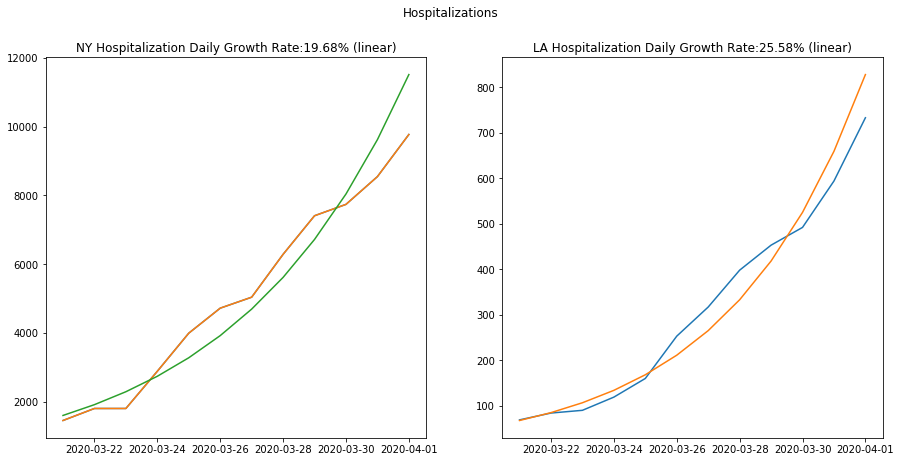

In [625]:
x = us.date
x0 = us.days
y = us.nyc_hospitalized.fillna(method='ffill').astype(int)

# plot cases

fig, axs = plt.subplots(1,2, figsize=(15,7))
fig.suptitle('Hospitalizations')
axs[0].plot(x, y)

#fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
axs[0].plot(x, y)

# fit #1: curve fit. Seeded with 33% national average and 7=first day of cases. 
#cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))
#plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))
#print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[0].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["ny_hosp_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)
us_all["ny_hosp_linear"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[0].set_title("NY Hospitalization Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))



#-----------

x = us.date
x0 = us.days
y = us.la_hospitalized

# plot cases
axs[1].plot(x, y)

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[1].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["la_hosp_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[1].set_title("LA Hospitalization Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))



LinregressResult(slope=0.1339681927849158, intercept=3.8315287478310185, rvalue=0.9940624389332713, pvalue=5.754245568890677e-11, stderr=0.004637260100863977) 1.1433564520816852
LinregressResult(slope=0.22266859431136085, intercept=1.4108710569270864, rvalue=0.9962751042132505, pvalue=5.612070426294225e-12, stderr=0.006094624431118326) 1.2494064447142168
9939.498620895867 6503.092888004992
LinregressResult(slope=0.17418665639683456, intercept=5.578427877599169, rvalue=0.9826877805292015, pvalue=1.1897119549272759e-08, stderr=0.010384913095047507) 1.1902777180367328
LinregressResult(slope=0.2529242725326726, intercept=0.912390002645382, rvalue=0.9926312515409318, pvalue=1.6899662994683459e-10, stderr=0.00976366567069985) 1.2877857523885485


Text(0.5,1,'BOS Cases Daily Growth Rate:28.78% (linear)')

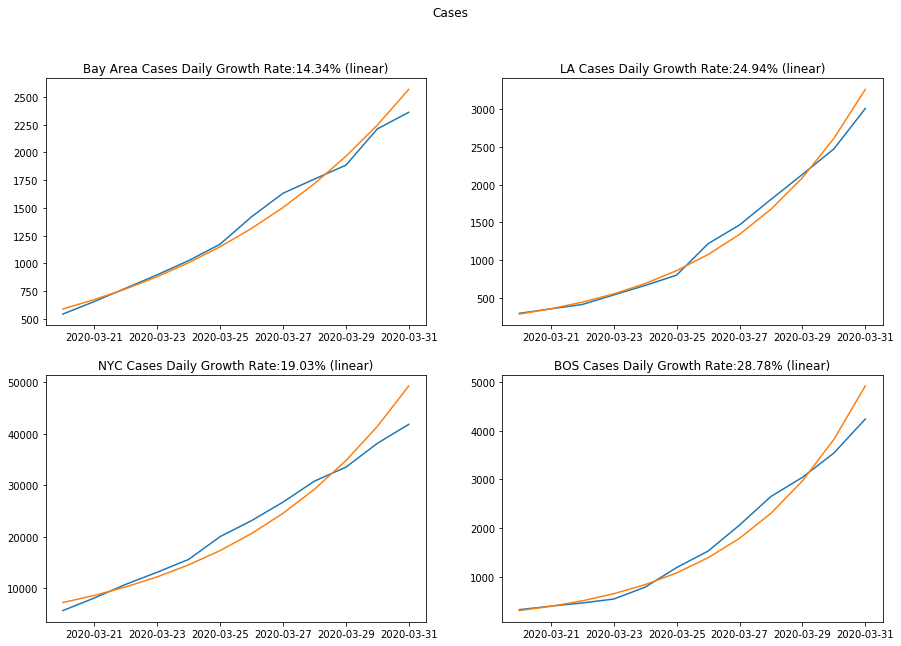

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [590]:
x = us.date
x0 = us.days
y = us.bay_area_cases.astype(int)


fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Cases')

# plot cases
fig.patch.set_facecolor('xkcd:white')
axs[0,0].plot(x, y)

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[0,0].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["sf_cases_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[0,0].set_title("Bay Area Cases Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))


x = us.date
x0 = us.days
y = us.la_cases

# plot cases
fig.patch.set_facecolor('xkcd:white')
axs[0,1].plot(x, y)

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[0,1].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["la_cases_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[0,1].set_title("LA Cases Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))


print np.exp(lr.intercept) * np.exp(lr.slope*(max(x0)+5)), 2136.0 * np.exp(lr.slope*5)


x = us.date
x0 = us.days
y = us.nyc_cases.astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
axs[1,0].plot(x, y)

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[1,0].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["nyc_cases_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[1,0].set_title("NYC Cases Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))

#-----
x = us.date
x0 = us.days
y = us.boscamnew_cases.astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
axs[1,1].plot(x, y)

# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
axs[1,1].plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us["bos_cases_exp"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# curve fit: (np.exp(cf[0][1]) - 1)*100
axs[1,1].set_title("BOS Cases Daily Growth Rate:{:0.2f}% (linear)".format((np.exp(lr.slope)-1)*100))




R^2 0.9740555805101446
LinregressResult(slope=0.397920285450427, intercept=0.0865877215996882, rvalue=0.9875806318239836, pvalue=7.281538721311933e-25, stderr=0.011755379268849672) 1.4887253521062858


Text(0.5,1,'NYC ALL Cases Daily Growth Rate:18.33% (curve) 48.87% (linear)')

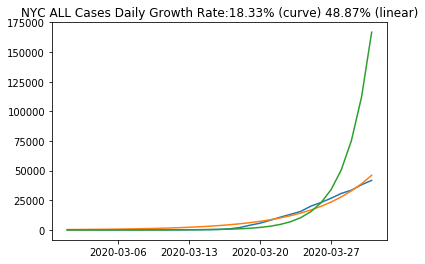

In [579]:
x = us_all.date
x0 = us_all.days
y = us_all.nyc_cases.astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y)



# curve fit
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))
plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))
us_all["nyc_cases_pred_curve"] = cf[0][0] * np.exp(cf[0][1]*x0)


# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
plt.plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
us_all["nyc_cases_pred_lin"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# 
plt.title("NYC ALL Cases Daily Growth Rate:{:0.2f}% (curve) {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100, (np.exp(lr.slope)-1)*100))


Text(0.5,1,'NYC Log Cases against 48.87% daily growth')

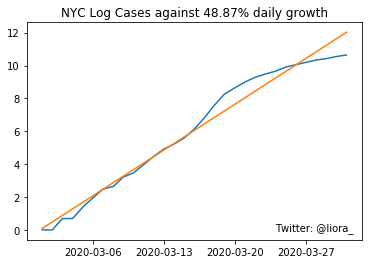

In [580]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y.map(np.log))
plt.plot(x, lr.intercept+lr.slope*x0)
us_all["nyc_cases_ln"] = y.map(np.log)
us_all["nyc_cases_ln_pred"] = lr.intercept+lr.slope*x0
plt.text(x.values[-8], 0, "Twitter: @liora_")
plt.title("NYC Log Cases against {:0.2f}% daily growth".format((np.exp(lr.slope)-1)*100))

In [591]:
us_all.to_csv("uscovid_pred.csv")
us.to_csv("uscovid_pred_short.csv")
#ln = us[["la_cases","nyc_cases","bay_area_cases"]].applymap(np.log)
#ln.to_csv("uscovid_transform.csv")
us_all

,date,us_cases_cnn,us_deaths_cnn,us_cases_covidtrack,us_negatives,us_pending,us_hospitalized,us_recovered,us_deaths_covidtrack,ca_cases,...,ny_discharged,nyc_cases,nyc_deaths,nyc_hospitalized,nyc_icu,seattle_king_county_cases,ma_cases,boscamnew_cases,days,ny_hosp_linear
1,2020-03-01,89,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0.0,NaN,NaN,22,NaN,NaN,0,NaN
2,2020-03-02,105,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0.0,NaN,NaN,24,NaN,NaN,1,NaN
3,2020-03-03,125,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2,0.0,NaN,NaN,38,NaN,NaN,2,NaN
4,2020-03-04,159,11,118,748,103,NaN,NaN,NaN,53,...,NaN,2,0.0,NaN,NaN,52,2.0,NaN,3,NaN
5,2020-03-05,227,12,176,953,197,NaN,NaN,NaN,53,...,NaN,4,0.0,NaN,NaN,63,2.0,NaN,4,NaN
6,2020-03-06,331,17,223,1571,458,NaN,NaN,NaN,60,...,NaN,7,0.0,NaN,NaN,101,8.0,NaN,5,NaN
7,2020-03-07,444,19,341,1809,602,NaN,NaN,NaN,69,...,NaN,12,0.0,NaN,NaN,121,13.0,NaN,6,NaN
8,2020-03-08,564,21,417,2335,347,NaN,NaN,NaN,88,...,NaN,14,0.0,NaN,NaN,159,13.0,NaN,7,NaN
9,2020-03-09,728,26,584,3367,313,NaN,NaN,NaN,114,...,NaN,25,0.0,NaN,NaN,225,41.0,NaN,8,NaN
10,2020-03-10,1000,31,778,3807,469,NaN,NaN,NaN,133,...,NaN,32,0.0,NaN,NaN,255,92.0,NaN,9,NaN


In [592]:
us

,date,days,la_cases,la_hospitalized,nyc_cases,nyc_hospitalized,bay_area_cases,boscamnew_cases,ny_hosp_exp,la_hosp_exp,sf_cases_exp,la_cases_exp,nyc_cases_exp,bos_cases_exp
20,2020-03-20,19,292.0,48.0,5683,1160.0,542,323.0,1245.878597,51.004518,588.116120,281.906188,7244.329828,304.280867
21,2020-03-21,20,351.0,69.0,8115,1450.0,655,395.0,1510.309646,64.689564,672.426360,352.215408,8622.764376,391.848566
22,2020-03-22,21,409.0,84.0,10764,1800.0,775,460.0,1830.864766,82.046451,768.823017,440.060201,10263.484305,504.617000
23,2020-03-23,22,536.0,90.0,13119,NaN,896,541.0,2219.455992,104.060371,879.038757,549.814051,12216.396677,649.838583
24,2020-03-24,23,662.0,119.0,15597,2883.0,1024,785.0,2690.523620,131.980857,1005.054635,686.941219,14540.904760,836.852869
25,2020-03-25,24,799.0,160.0,20011,3992.0,1172,1187.0,3261.572826,167.392702,1149.135701,858.268786,17307.714936,1077.687201
26,2020-03-26,25,1216.0,253.0,23112,4720.0,1419,1525.0,3953.824162,212.305914,1313.871718,1072.326552,20600.987438,1387.830223
27,2020-03-27,26,1465.0,317.0,26697,5039.0,1631,2059.0,4793.002130,269.269812,1502.223706,1339.771705,24520.896317,1787.227988
28,2020-03-28,27,1804.0,398.0,30765,6287.0,1759,2647.0,5810.291121,341.517718,1717.577167,1673.919403,29186.676513,2301.566739
29,2020-03-29,28,2136.0,453.0,33474,7410.0,1884,3039.0,7043.494244,433.150494,1963.802936,2091.405690,34740.250717,2963.924855


# MA

In [431]:
ma = pd.read_csv("macovid.csv")
ma.set_index(ma.columns[0],inplace=True)
ma = ma[ma.sum(axis=1) != 0].T
ma.index = pd.to_datetime(ma.index)
ma["days"] = ((ma.index - ma.index.min()) /  86400000000000).astype(int)
ma

Unnamed: 0,Total,Barnstable,Berkshire,Bristol,Dukes and Nantucket,Essex,Franklin,Hampden,Hampshire,Middlesex,...,Biogen conference attendees and household contacts,Local transmission,Travel related,Exposure Under investigation,Attributed to COVID-19,Patient was hospitalized,Patient was not hospitalized,Hospitalization Under Investigation,Boston-Cambridge-Newton,days
2020-03-16,197.0,1.0,11.0,2.0,NaN,8.0,NaN,1.0,NaN,83.0,...,100.0,28.0,18.0,51.0,NaN,14.0,123.0,60.0,163.0,0
2020-03-17,218.0,2.0,14.0,5.0,NaN,8.0,NaN,1.0,NaN,89.0,...,102.0,33.0,24.0,59.0,NaN,21.0,145.0,52.0,182.0,1
2020-03-18,256.0,2.0,17.0,5.0,NaN,14.0,1.0,2.0,NaN,100.0,...,97.0,38.0,26.0,95.0,NaN,27.0,151.0,78.0,210.0,2
2020-03-19,328.0,5.0,18.0,6.0,NaN,19.0,1.0,3.0,1.0,119.0,...,97.0,46.0,34.0,151.0,NaN,43.0,160.0,125.0,262.0,3
2020-03-20,413.0,9.0,20.0,6.0,NaN,29.0,1.0,3.0,2.0,144.0,...,97.0,63.0,49.0,204.0,1.0,58.0,199.0,156.0,323.0,4
2020-03-21,525.0,11.0,21.0,14.0,1.0,41.0,2.0,9.0,2.0,177.0,...,97.0,69.0,53.0,306.0,1.0,61.0,215.0,249.0,395.0,5
2020-03-22,646.0,24.0,23.0,24.0,1.0,60.0,2.0,12.0,4.0,199.0,...,99.0,83.0,68.0,396.0,5.0,71.0,263.0,312.0,460.0,6
2020-03-23,777.0,30.0,26.0,25.0,1.0,73.0,2.0,15.0,6.0,232.0,...,99.0,104.0,75.0,499.0,9.0,79.0,286.0,412.0,541.0,7
2020-03-24,1159.0,40.0,37.0,31.0,2.0,118.0,5.0,24.0,8.0,304.0,...,99.0,120.0,86.0,854.0,11.0,94.0,313.0,752.0,785.0,8
2020-03-25,1838.0,51.0,71.0,67.0,3.0,177.0,14.0,45.0,11.0,446.0,...,99.0,146.0,92.0,1501.0,15.0,103.0,350.0,1385.0,1187.0,9


R^2 0.9860072027415189
LinregressResult(slope=0.23836034039149595, intercept=4.876176715367949, rvalue=0.9930202073508498, pvalue=1.8666439664230183e-13, stderr=0.007852019078555381) 1.2691664423699403


TypeError: float argument required, not Timestamp

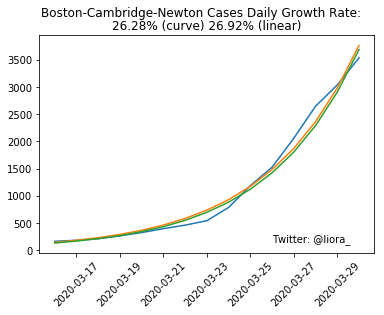

In [435]:
x = ma.index
x0 = ma.days
y = ma["Boston-Cambridge-Newton"].astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y)



# curve fit
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))
plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))
#us_all["nyc_cases_pred_curve"] = cf[0][0] * np.exp(cf[0][1]*x0)


# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
plt.plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
#us_all["nyc_cases_pred_lin"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# 
plt.title("{:0.2f}% (curve) {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100, (np.exp(lr.slope)-1)*100))
plt.xticks(rotation=45)
plt.suptitle("Boston-Cambridge-Newton Cases Daily Growth Rate:")
plt.text(x[-5], y[0], "Twitter: @liora_")

# NYC

In [461]:
nyc = pd.read_csv("nyccovid.csv", header = [0,1], index_col=[0])
nyc.index = pd.to_datetime(nyc.index)
nyc["days"] = ((nyc.index - nyc.index.min()) /  86400000000000).astype(int)
nyc

Cases                                                          \
           Bronx Brooklyn Manhattan Queens Staten Island Borough Unknown   
2020-03-12    10       24        25     17             5             NaN   
2020-03-15    21       53        72     78            16             NaN   
2020-03-16    34       62       111    118            19             NaN   
2020-03-17    96      157       277    248            36             NaN   
2020-03-19   436     1030       976    980           165             NaN   
2020-03-20   736     1740      1402   1514           285             6.0   
2020-03-21  1071     2484      1868   2254           437             NaN   
2020-03-22  1564     3154      2324   3050           666             NaN   
2020-03-23  1829     3494      2572   3621           817             6.0   
2020-03-24  2505     4407      3013   4667           999             6.0   
2020-03-25  3542     5232      3616   6420          1166            35.0   
2020-03-26  4243     6095      4046   7362          1330            36.0   
2020-03-27  4880     7091      4627   8529          1534            36.0   
2020-03-28  5752     8129      5237   9831          1781            35.0   
2020-03-29  6250     8887      5582  10737          1984            34.0   
2020-03-30  6925    10171      6060  12756          2140            35.0   

                                                        ... Ever Hospitalized  \
           Age Median Age Youngest Age Oldest Age 0-17  ...            Female   
2020-03-12        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-15        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-16        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-17        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-19        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-20        NaN          NaN        NaN    157.0  ...               NaN   
2020-03-21        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-22        NaN          NaN        NaN      NaN  ...               NaN   
2020-03-23       45.0          0.0      105.0    323.0  ...               NaN   
2020-03-24       46.0          0.0      105.0    384.0  ...            1191.0   
2020-03-25       46.0          0.0      105.0    446.0  ...            1628.0   
2020-03-26       47.0          0.0      105.0    495.0  ...            1918.0   
2020-03-27       47.0          0.0      105.0    543.0  ...            2035.0   
2020-03-28       48.0          0.0      105.0    591.0  ...            2545.0   
2020-03-29       48.0          0.0      105.0    619.0  ...            3001.0   
2020-03-30       48.0          0.0      105.0    714.0  ...            3130.0   

                                                                      \
              Male Gender Unknown   Bronx Brooklyn Manhattan  Queens   
2020-03-12     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-15     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-16     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-17     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-19     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-20     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-21     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-22     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-23     NaN            NaN     NaN      NaN       NaN     NaN   
2020-03-24  1691.0            1.0   600.0    637.0     417.0  1037.0   
2020-03-25  2293.0            1.0   802.0    919.0     584.0  1363.0   
2020-03-26  2801.0            1.0  1071.0    968.0     729.0  1659.0   
2020-03-27  3003.0            1.0  1200.0    989.0     709.0  1810.0   
2020-03-28  3741.0            1.0  1433.0   1372.0     916.0  2181.0   
2020-03-29  4408.0            1

In [462]:
# BRONX ONLY (should look like rest of NYC)
bronx = nyc[[("days",""),("Cases","Bronx"),("Ever Hospitalized","Bronx"),("Deaths","Bronx")]]
bronx.columns = bronx.columns.droplevel(level=1)
bronx

,days,Cases,Ever Hospitalized,Deaths
2020-03-12,0,10,NaN,NaN
2020-03-15,3,21,NaN,NaN
2020-03-16,4,34,NaN,NaN
2020-03-17,5,96,NaN,NaN
2020-03-19,7,436,NaN,NaN
2020-03-20,8,736,NaN,NaN
2020-03-21,9,1071,NaN,NaN
2020-03-22,10,1564,NaN,14.0
2020-03-23,11,1829,NaN,28.0
2020-03-24,12,2505,600.0,41.0


R^2 0.9633684576903788
LinregressResult(slope=0.39115644403911576, intercept=2.729823091474039, rvalue=0.9610383412988474, pvalue=3.2963284958499586e-09, stderr=0.03006820609062845) 1.478689827528036


TypeError: float argument required, not Timestamp

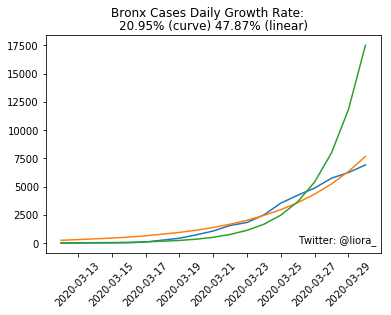

In [466]:
x = bronx[bronx.Cases.notnull()].index
x0 = bronx[bronx.Cases.notnull()].days
y = bronx[bronx.Cases.notnull()].Cases.astype(int)

# plot cases
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y)



# curve fit
cf = curve_fit(lambda t,a,b: a*np.exp(b*t),  x0,  y,  p0=(100, np.log(1.33)))
plt.plot(x, cf[0][0] * np.exp(cf[0][1]*x0))
print "R^2", r2_score(y, cf[0][0] * np.exp(cf[0][1]*x0))
#us_all["nyc_cases_pred_curve"] = cf[0][0] * np.exp(cf[0][1]*x0)


# LR
lr = linregress(x0, y=y.map(np.log))
print lr, np.exp(lr.slope)
plt.plot(x, np.exp(lr.intercept) * np.exp(lr.slope*x0))
#us_all["nyc_cases_pred_lin"] = np.exp(lr.intercept) * np.exp(lr.slope*x0)

# Show both growth rates in the title. 
# 
plt.title("{:0.2f}% (curve) {:0.2f}% (linear)".format((np.exp(cf[0][1]) - 1)*100, (np.exp(lr.slope)-1)*100))
plt.xticks(rotation=45)
plt.suptitle("Bronx Cases Daily Growth Rate:")
plt.xticks(rotation=45)
plt.text(x[-5], y[0], "Twitter: @liora_")

(array([737497., 737499., 737501., 737503., 737505., 737507., 737509.,
        737511., 737513.]), <a list of 9 Text xticklabel objects>)

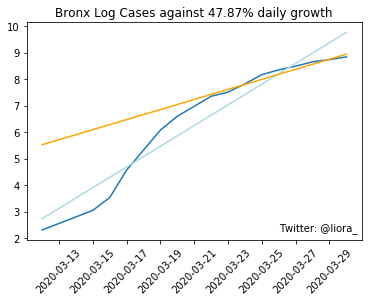

In [482]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y.map(np.log))
plt.plot(x, lr.intercept+lr.slope*x0, c='lightblue')
plt.plot(x, np.log(cf[0][0]) + x0*(cf[0][1]), c='orange')
#us_all["nyc_cases_ln"] = y.map(np.log)
#us_all["nyc_cases_ln_pred"] = lr.intercept+lr.slope*x0
plt.title("Bronx Log Cases against {:0.2f}% daily growth".format((np.exp(lr.slope)-1)*100))
plt.text(x[-5], np.log(y[0]), "Twitter: @liora_")
plt.xticks(rotation=45)
